In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit

In [2]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

ajak = ccm_alav(leff['J'],3.1)/ccm_alav(leff['K'],3.1)
ahak = ccm_alav(leff['H'],3.1)/ccm_alav(leff['K'],3.1)

In [165]:
from dlnpyutils import robust
from scipy.stats import binned_statistic, binned_statistic_2d
from tqdm import tqdm_notebook

# Parsec Isochrones

In [3]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

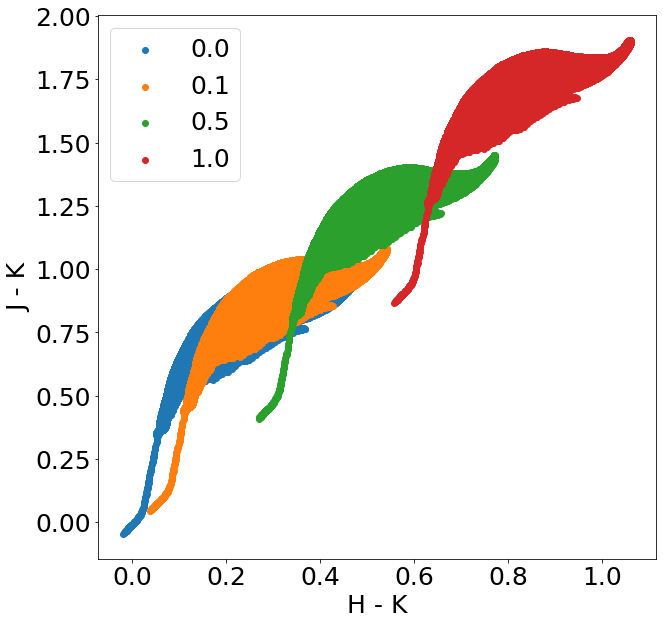

In [4]:
aks = np.array([0,0.1,0.5,1.0])

plt.figure(figsize=[10,10])

for i in range(4):

    plt.scatter((massive['Hmag']+ahak*aks[i])-(massive['Ksmag']+aks[i]),
                (massive['Jmag']+ajak*aks[i])-(massive['Hmag']+ahak*aks[i]),label='{}'.format(aks[i]))

plt.legend()
plt.xlabel(r'H - K')
plt.ylabel(r'J - K')

plt.show()

# APOKASC 

In [ ]:
# from astropy.io import ascii
# kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
# kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')

# ### xmatch DR17
# dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')
# _, kasc672_ind, dr17_ind = np.intersect1d(kasc672['2MASS_ID'],dr17['APOGEE_ID'], return_indices=True)

# kascdr17 = dr17[dr17_ind]
# kasc672 = kasc672[kasc672_ind]

# ### xmatch kasc2 and kasc3
# _, kasc3_ind, kasc672_ind = np.intersect1d(kasc3['2MASSID'],kasc672['2MASS_ID'], return_indices=True)

# kasc672 = kasc672[kasc672_ind]
# kasc3dr17 = kascdr17[kasc672_ind]
# kasc3 = kasc3[kasc3_ind]

# apoafe = kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H']
# apoafe_err = np.sqrt(kasc3dr17['ALPHA_M']**2+kasc3dr17['M_H']**2-kasc3dr17['FE_H']**2)

# ageevs = np.where((kasc3['IntAge']>-10.)&(kasc672['APOKASC3_CONS_EVSTATES']==1.0)&
#                   (kasc3dr17['GAIAEDR3_PARALLAX']/kasc3dr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

# kasc672 = kasc672[ageevs]
# kasc3dr17 = kascdr17[ageevs]
# kasc3 = kasc3[ageevs]

<ipython-input-102-ea4b86b12b0d>:28: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)


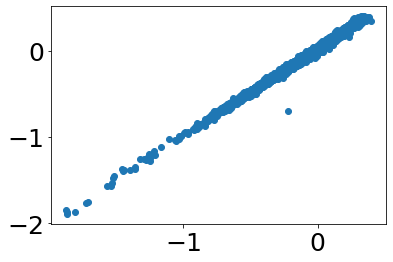

In [102]:
from astropy.io import ascii

kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')

# xmatch APOKASC Catalogs
_, k672idx, k3idx = np.intersect1d(kasc672['2MASS_ID'],kasc3['2MASSID'],return_indices=True)
k672 = kasc672[k672idx]
k3 = kasc3[k3idx]

# xmatch APOKASC with DR17
_, k3idx, dr17idx = np.intersect1d(k3['2MASSID'],dr17['APOGEE_ID'],return_indices=True)

k672dr17 = k672[k3idx]
k3dr17 = k3[k3idx]
kdr17 = dr17[dr17idx]

# Select RGB stars
ageevs = np.where((k3dr17['IntAge']>-10.)&(k672dr17['APOKASC3_CONS_EVSTATES']==1.0)&
                  (kdr17['GAIAEDR3_PARALLAX']/kdr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

k672dr17 = k672dr17[ageevs]
k3dr17 = k3dr17[ageevs]
kdr17 = kdr17[ageevs]

apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

plt.scatter(kdr17['FE_H'],k3dr17['Fe/H'])

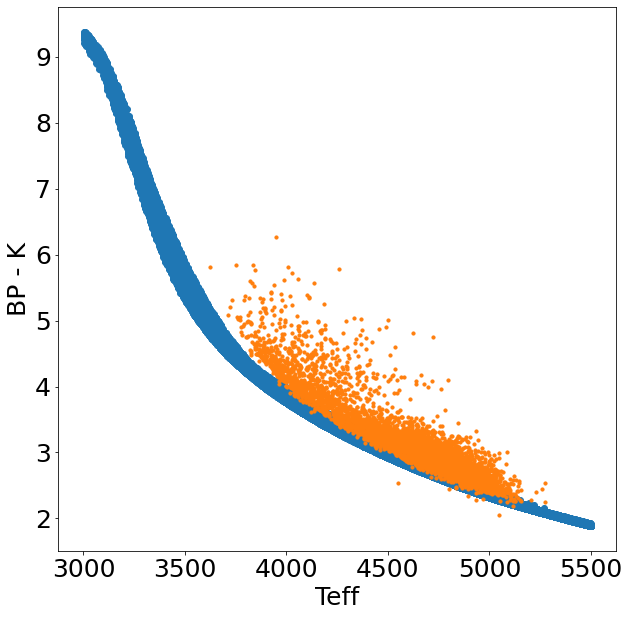

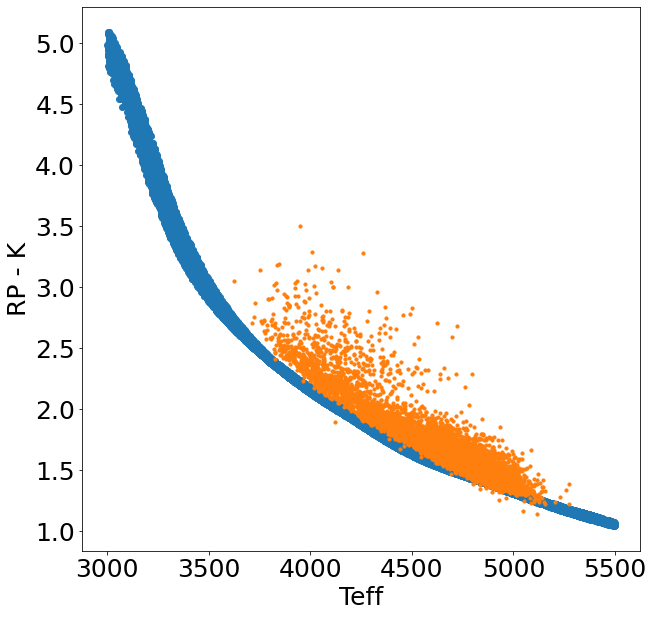

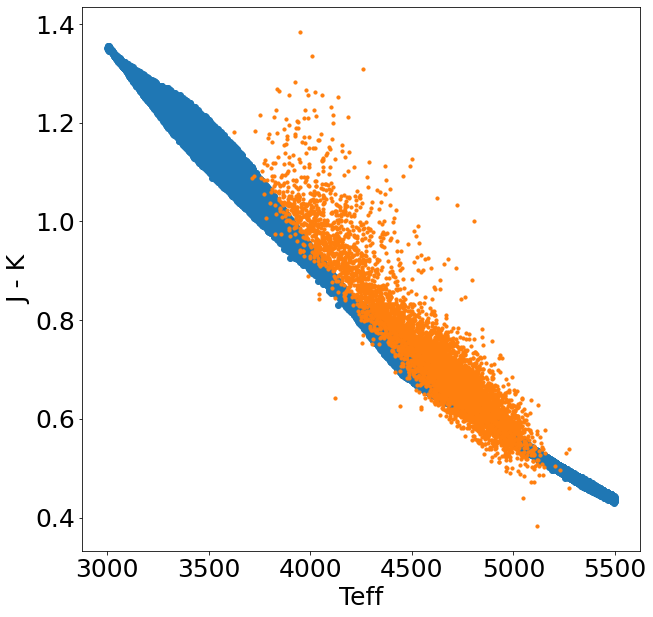

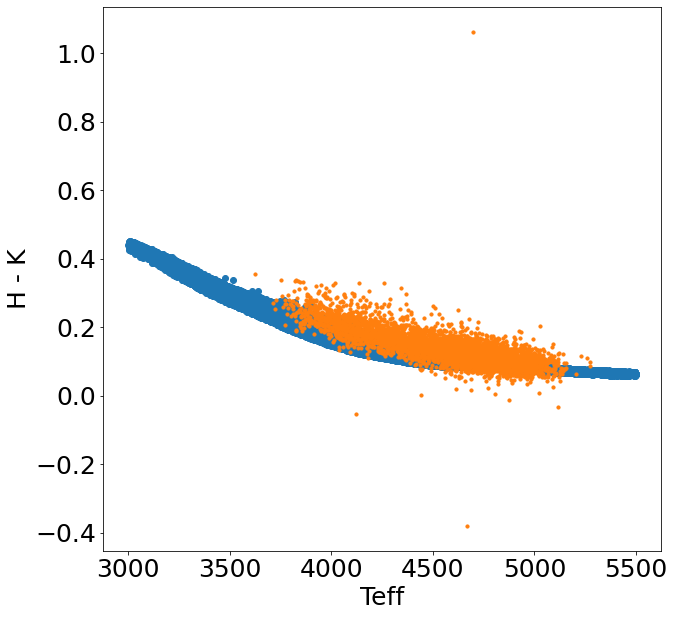

In [375]:
pfilters = np.array(['G_BPmag','G_RPmag','Jmag','Hmag'])
kfilters = np.array(['GAIAEDR3_PHOT_BP_MEAN_MAG','GAIAEDR3_PHOT_RP_MEAN_MAG','J','H'])
ylabels = np.array(['BP - K','RP - K','J - K','H - K'])

teffcut = np.where((massive['logTe']<np.log10(5500.))&(massive['logTe']>np.log10(3000.)))

for i in range(len(pfilters)):

    plt.figure(figsize=[10,10])
    plt.scatter(10**massive['logTe'][teffcut][::50],(massive[pfilters[i]]-massive['Ksmag'])[teffcut][::50])
    plt.scatter(kdr17['TEFF'],kdr17[kfilters[i]]-kdr17['K'],s=10)
    plt.xlabel('Teff')
    plt.ylabel(r'{}'.format(ylabels[i]))
    plt.savefig('../plots/colorteff_{}APOKASC.pdf'.format(kfilters[i]),bbox_inches='tight')
    plt.show()

In [103]:
# ### Resd in APOKASC Catalogs
# from astropy.io import ascii
# kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
# kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')

# ### xmatch the APOKASC Catlaogs
# _, k3_idx, k672_idx = np.intersect1d(kasc3['2MASSID'],kasc672['2MASS_ID'],return_indices=True)

# kasc672 = kasc672[k672_idx]
# kasc3 = kasc3[k3_idx]

# ### Check
# print(np.where((kasc3['2MASSID']==kasc672['2MASS_ID'])==False))

# ### Read in DR17
# dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')

# ### xmatch APOKASC and APOGEE
# _, kasc_idx, apo_idx = np.intersect1d(kasc3['2MASSID'],dr17['APOGEE_ID'],return_indices=True)

# kasc672 = kasc672[kasc_idx]
# kasc3 = kasc3[kasc_idx]
# kasc3dr17 = dr17[apo_idx] 

# ### Select RGB stars
# ageevs = np.where((kasc3['IntAge']>-10.)&(kasc672['APOKASC3_CONS_EVSTATES']==1.0)&
#                   (kasc3dr17['GAIAEDR3_PARALLAX']/kasc3dr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

# kasc672 = kasc672[ageevs]
# kasc3 = kasc3[ageevs]
# kasc3dr17 = dr17[ageevs] 

In [104]:
# dr16 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-r12-l33.fits.gz')

# #### dr16 last
# _, d16test, d17test = np.intersect1d(dr16['APOGEE_ID'],kasc3dr17['APOGEE_ID'], return_indices=True)

# dr16test = dr16[d16test]
# kasc3dr17test = kasc3dr17[d17test]
# kasc3test = kasc3[d17test]
# ksc672test = kasc672[d17test]

In [105]:
# kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
# kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')

# ### Check
# print(np.where((kasc3['2MASSID']==kasc672['2MASS_ID'])==False))

# ### dr16
# _, d16idx, d17idx = np.intersect1d(dr16['APOGEE_ID'],dr17['APOGEE_ID'], return_indices=True)

# kasc672 = kasc672[d17idx]
# kasc3 = kasc3[d17idx]
# dr17a = dr17[d17idx]
# dr16a = dr16[d16idx]

In [106]:
# _, d16_idx, d17_idx = np.intersect1d(dr16['APOGEE_ID'],dr17['APOGEE_ID'], return_indices=True)
# d16 = dr16[d16_idx]
# d17 = dr17[d17_idx]

# _, k_idx, a_idx = np.intersect1d(kasc3['2MASSID'],d17['APOGEE_ID'], return_indices=True)

# d16 = d16[a_idx]
# d17 = d17[a_idx]
# ka3 = kasc3[k_idx]

# Gaia Magnitude Errors

In [107]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

In [108]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

# [Fe/H]

In [109]:
finfeh = np.where((np.isfinite(kdr17['FE_H'])==True)&(np.isfinite(k3dr17['Fe/H'])==True))

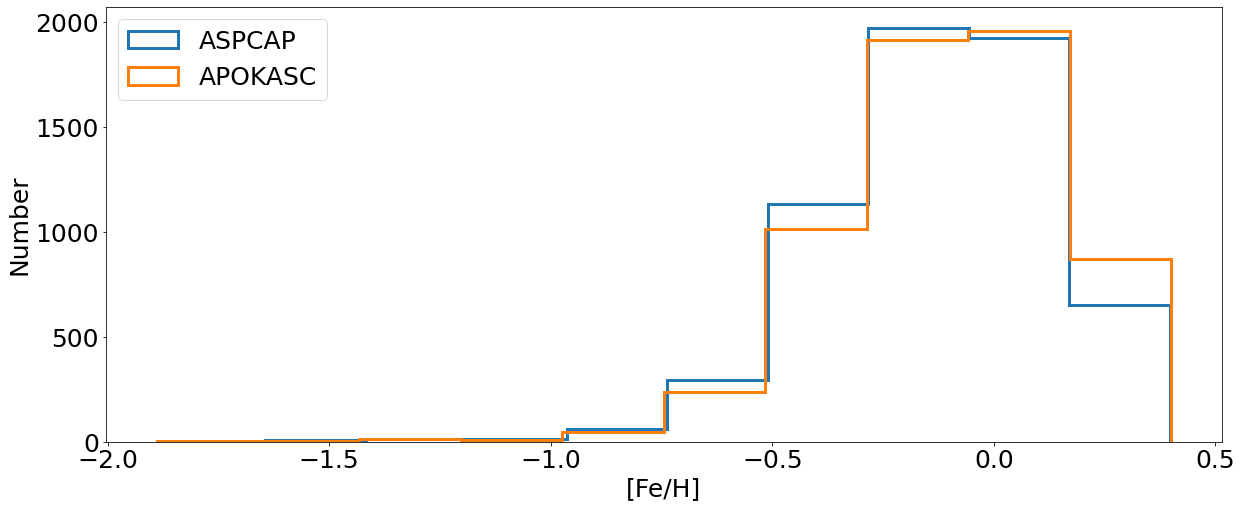

In [110]:
plt.figure(figsize=[20,8])
plt.hist(kdr17['FE_H'],histtype='step',lw=3.0,label='ASPCAP')
plt.hist(k3dr17['Fe/H'],histtype='step',lw=3.0,label='APOKASC')
plt.legend(loc='upper left')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Number')
# plt.savefig('../plots/kasc_aspcap_feh_hist.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [111]:
k3dr17.columns

<TableColumns names=('KICID','Mass','Logg','Fe/H','Al/Fe','Teff','C/N','M_err','Logg_err','Fe/H_err','Al/Fe_err','Teff_err','2MASSID','IntTeff','IntML','IntAge','IntC12','IntC13','IntN14','IntXsurf')>

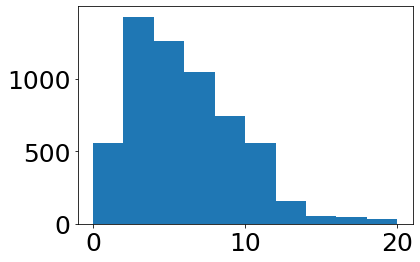

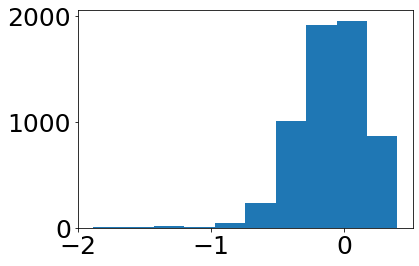

(-3.8320285, 20.0)

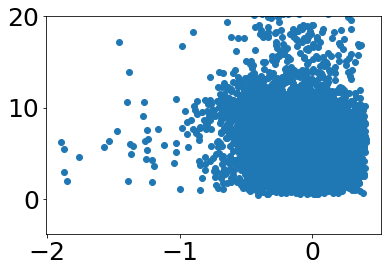

In [112]:
plt.hist(k3dr17['IntAge'],range=(0,20))
plt.show()

plt.hist(k3dr17['Fe/H'])
plt.show()

plt.scatter(k3dr17['Fe/H'],k3dr17['IntAge'])
plt.ylim(top=20)

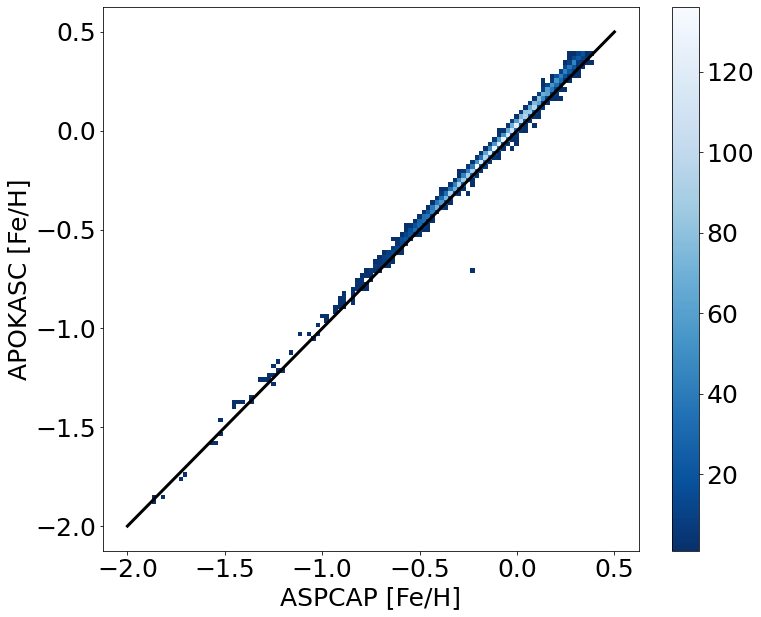

In [124]:
ret = binned_statistic_2d(kdr17['FE_H'][finfeh],k3dr17['Fe/H'][finfeh],
                          kdr17['FE_H'][finfeh],'count',bins=100)

ret.statistic[ret.statistic == 0.0] = np.nan

### Plot
plt.figure(figsize=[12,10])

plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
       aspect='auto',interpolation='nearest',cmap='Blues_r')

plt.colorbar()

# plt.figure(figsize=[10,10])
plt.plot([-2,0.5],[-2,0.5],c='k',lw=3.0)

plt.xlabel(r'ASPCAP [Fe/H]')
plt.ylabel(r'APOKASC [Fe/H]')

plt.savefig('../plots/kasc_aspcap_feh_density.pdf',dpi=300,bbox_inches='tight')
plt.show()

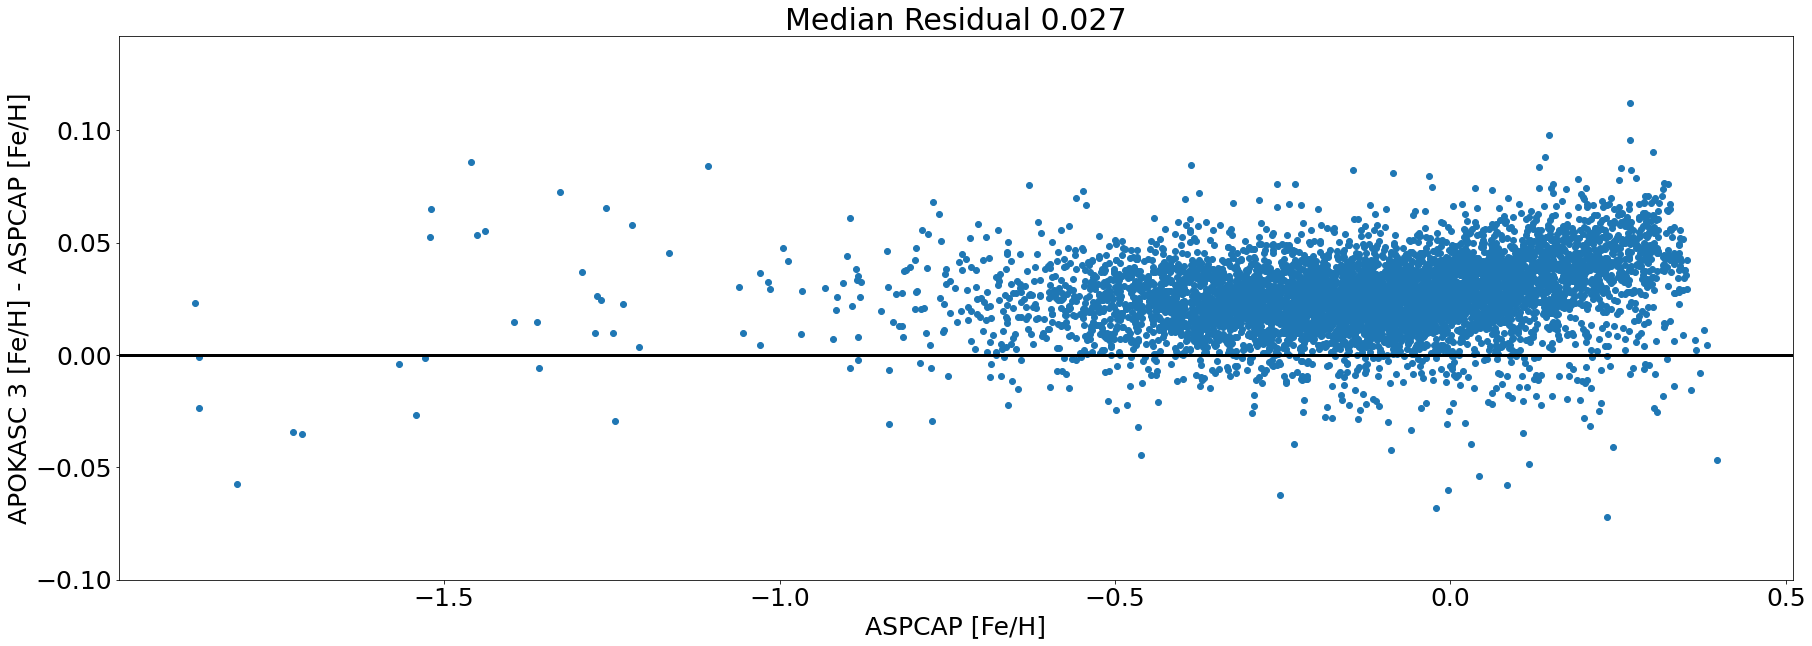

In [125]:
plt.figure(figsize=[30,10])
plt.scatter(kdr17['FE_H'][finfeh],k3dr17['Fe/H'][finfeh]-kdr17['FE_H'][finfeh])

plt.axhline(0.0,c='k',lw=3.0)

plt.title(r'Median Residual {:.3f}'.format(np.median(k3dr17['Fe/H'][finfeh]-kdr17['FE_H'][finfeh])))
plt.xlabel(r'ASPCAP [Fe/H]')
plt.ylabel(r'APOKASC 3 [Fe/H] - ASPCAP [Fe/H]')
plt.ylim(bottom=-0.1)
plt.savefig('../plots/kasc_aspcap_feh_resid_density.pdf',dpi=300,bbox_inches='tight')

[0.01872331 0.02949475]


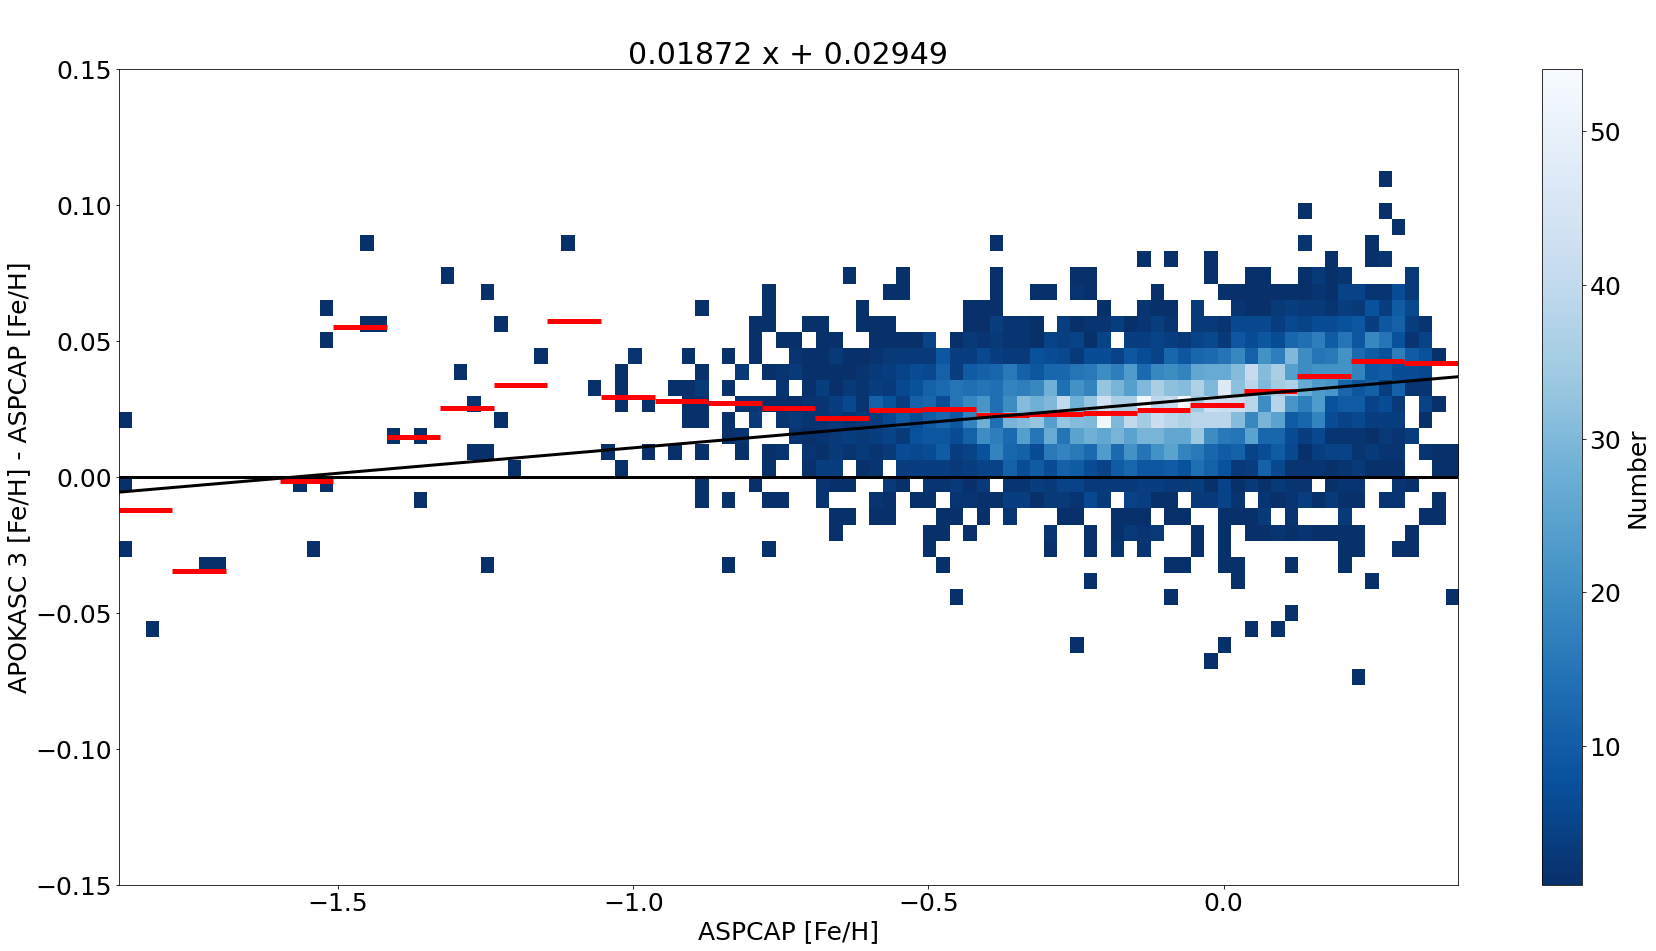

In [121]:
coeff = robust.polyfit(kdr17['FE_H'][finfeh],(k3dr17['Fe/H']-kdr17['FE_H'])[finfeh],1)
print(coeff)

page = np.poly1d(coeff)

### residuals

bin_means, bin_edges, _ = binned_statistic(kdr17['FE_H'][finfeh],(k3dr17['Fe/H']-kdr17['FE_H'])[finfeh],
                                           statistic='median',bins=25)
### number

ret = binned_statistic_2d(kdr17['FE_H'][finfeh],(k3dr17['Fe/H']-kdr17['FE_H'])[finfeh],
                          kdr17['FE_H'][finfeh],'count',bins=100)

ret.statistic[ret.statistic == 0.0] = np.nan

### Plot
plt.figure(figsize=[30,15])

plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
       aspect='auto',interpolation='nearest',cmap='Blues_r')
cbar = plt.colorbar()
cbar.set_label('Number')

plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5.)
plt.axhline(0.,c='k',lw=3.0)

plt.ylim(-0.15,0.15)

polyxs = np.linspace(min(kdr17['FE_H'][finfeh]),max(kdr17['FE_H'][finfeh]))

plt.plot(polyxs,page(polyxs),c='k',lw=3.0)

plt.title(r'{}'.format(page))
plt.xlabel(r'ASPCAP [Fe/H]')
plt.ylabel(r'APOKASC 3 [Fe/H] - ASPCAP [Fe/H]')

plt.savefig('../plots/kasc_feh_resid_2dhist.pdf',dpi=300,bbox_inches='tight')
plt.show()

# Isochrone Plots

It might be interesting to try something similar to what they did in the Alist paper.
Take a narrow range in metallicity and APOKASC3 age, then plot those stars in
logg vs. Teff (using APOKASC logg) and overplot the isochrone to compare.
You can then do this for a variety of metallicities and ages.

(-0.1, 0.14194499574422836)

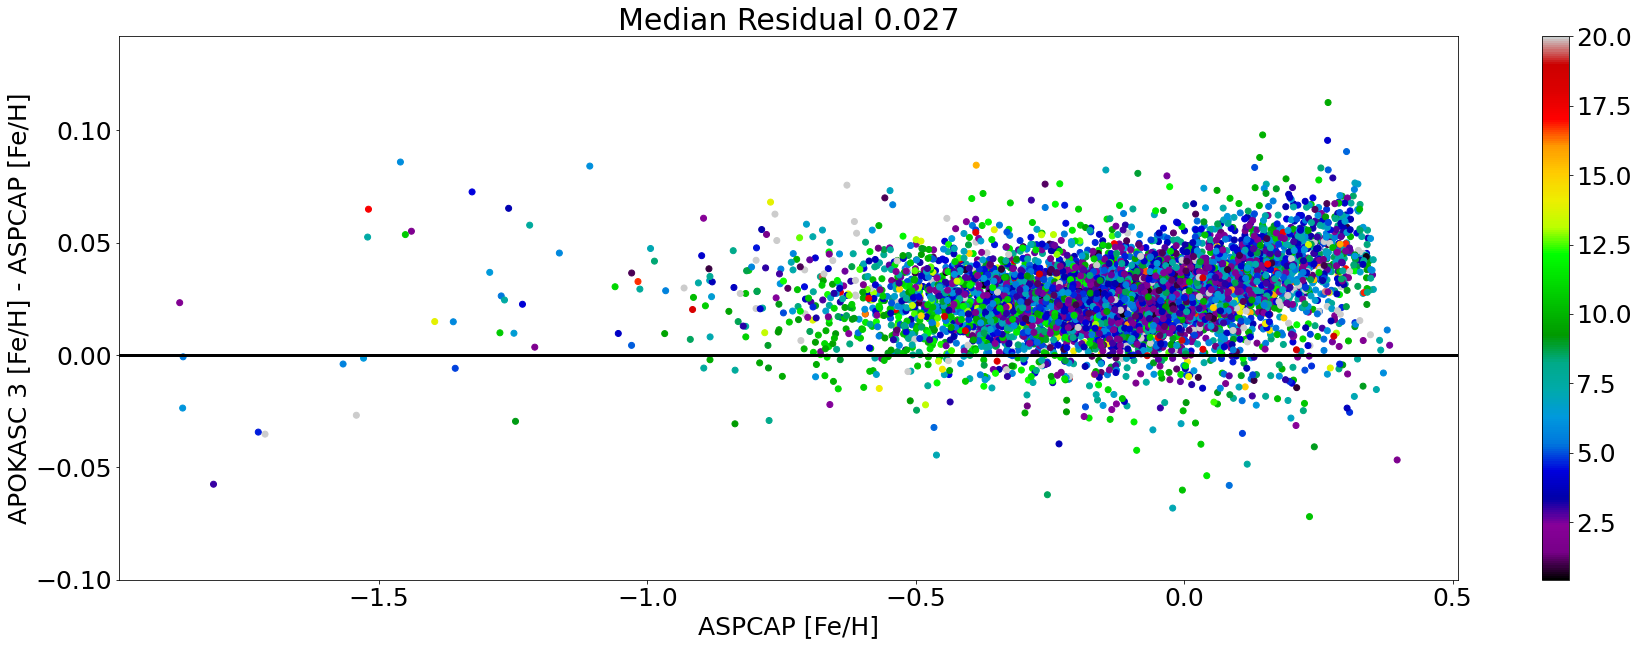

In [131]:
plt.figure(figsize=[30,10])
plt.scatter(kdr17['FE_H'][finfeh],k3dr17['Fe/H'][finfeh]-kdr17['FE_H'][finfeh],
            c=k3dr17['IntAge'][finfeh],cmap='nipy_spectral',vmax=20)
plt.colorbar()

plt.axhline(0.0,c='k',lw=3.0)

plt.title(r'Median Residual {:.3f}'.format(np.median(k3dr17['Fe/H'][finfeh]-kdr17['FE_H'][finfeh])))
plt.xlabel(r'ASPCAP [Fe/H]')
plt.ylabel(r'APOKASC 3 [Fe/H] - ASPCAP [Fe/H]')
plt.ylim(bottom=-0.1)

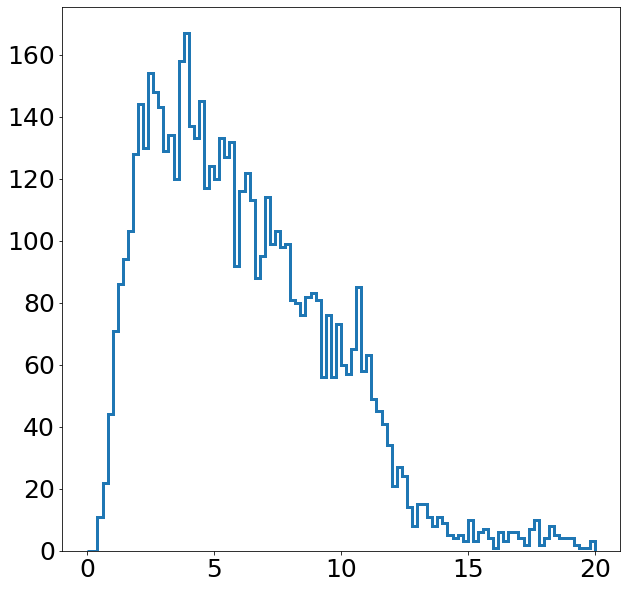

In [161]:
min(k3dr17['IntAge'])
plt.figure(figsize=[10,10])
plt.hist(k3dr17['IntAge'],range=(0,20),bins=100,histtype='step',lw=3.0)
plt.show()

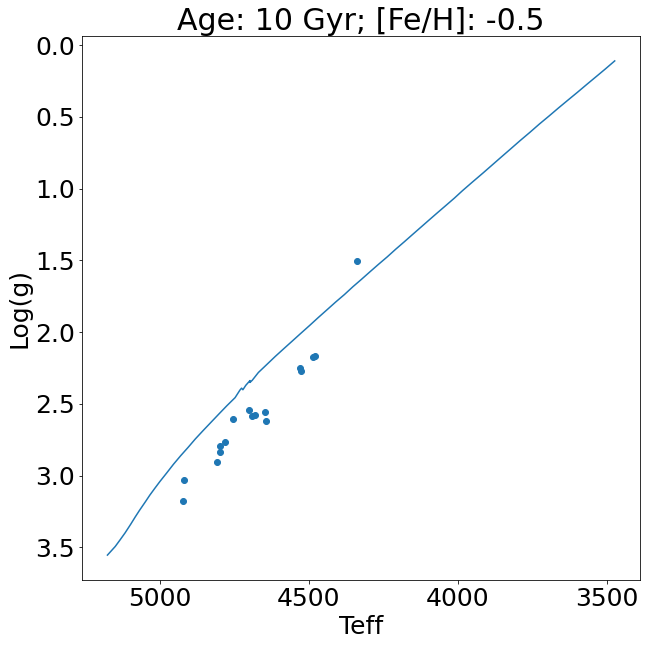

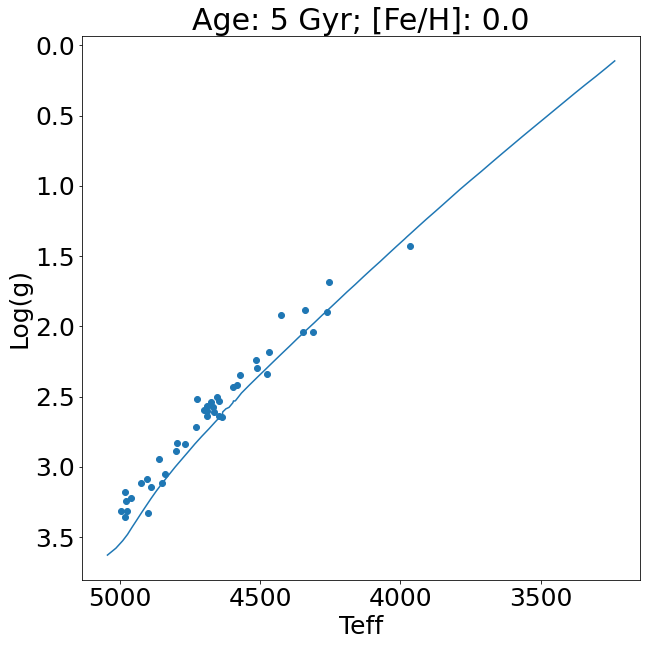

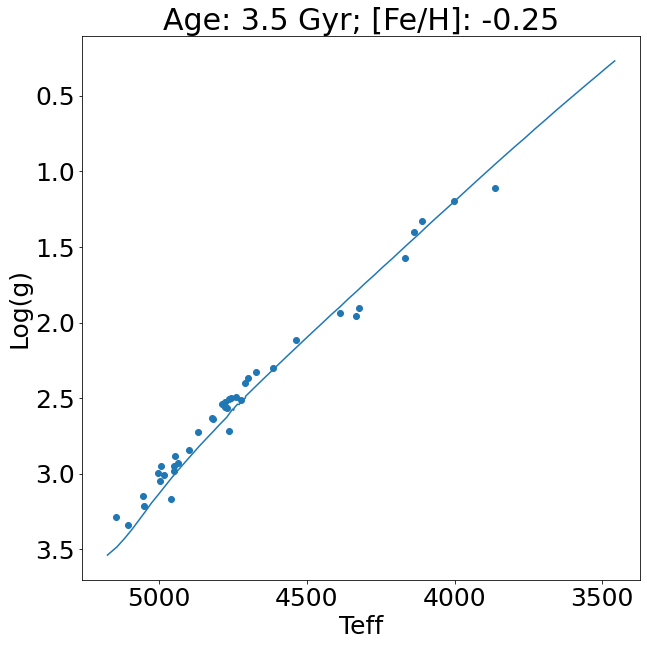

In [154]:
### Age: 10 Gyr; [Fe/H]: -0.5
f_05a10 = np.where((k3dr17['IntAge']>=9.75)&(k3dr17['IntAge']<=10.25)&
                  (k3dr17['Fe/H']<=-0.45)&(k3dr17['Fe/H']>=-0.55))

iso_f_05a10 = massive[np.where((massive['MH']==closest(massive['MH'],-0.5))&
                              (massive['logAge']==closest(massive['logAge'],np.log10(10*10**9))))]

iso_f_05a10 = iso_f_05a10[np.argsort(iso_f_05a10['logTe'])]

plt.figure(figsize=[10,10])
plt.scatter(k3dr17['Teff'][f_05a8],k3dr17['Logg'][f_05a8])

plt.plot(10**iso_f_05a10['logTe'],iso_f_05a10['logg'])

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Age: 10 Gyr; [Fe/H]: -0.5')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')
plt.show()


### Age: 5 Gyr; [Fe/H]: 0.0
f00a5 = np.where((k3dr17['IntAge']>=4.75)&(k3dr17['IntAge']<=5.25)&
                  (k3dr17['Fe/H']<=0.05)&(k3dr17['Fe/H']>=-0.05))

iso_f00a5 = massive[np.where((massive['MH']==closest(massive['MH'],0.0))&
                              (massive['logAge']==closest(massive['logAge'],np.log10(5*10**9))))]

iso_f00a5 = iso_f00a5[np.argsort(iso_f00a5['logTe'])]

plt.figure(figsize=[10,10])
plt.scatter(k3dr17['Teff'][f00a5],k3dr17['Logg'][f00a5])

plt.plot(10**iso_f00a5['logTe'],iso_f00a5['logg'])

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Age: 5 Gyr; [Fe/H]: 0.0')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')
plt.show()


### Age: 3.5 Gyr; [Fe/H]: -0.25
f_025a35 = np.where((k3dr17['IntAge']>=3.25)&(k3dr17['IntAge']<=3.75)&
                  (k3dr17['Fe/H']<=-0.20)&(k3dr17['Fe/H']>=-0.30))

iso_f_025a35 = massive[np.where((massive['MH']==closest(massive['MH'],-0.25))&
                              (massive['logAge']==closest(massive['logAge'],np.log10(3.5*10**9))))]

iso_f_025a35 = iso_f_025a35[np.argsort(iso_f_025a35['logTe'])]

plt.figure(figsize=[10,10])
plt.scatter(k3dr17['Teff'][f_025a35],k3dr17['Logg'][f_025a35])

plt.plot(10**iso_f_025a35['logTe'],iso_f_025a35['logg'])

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Age: 3.5 Gyr; [Fe/H]: -0.25')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')
plt.show()

In [ ]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

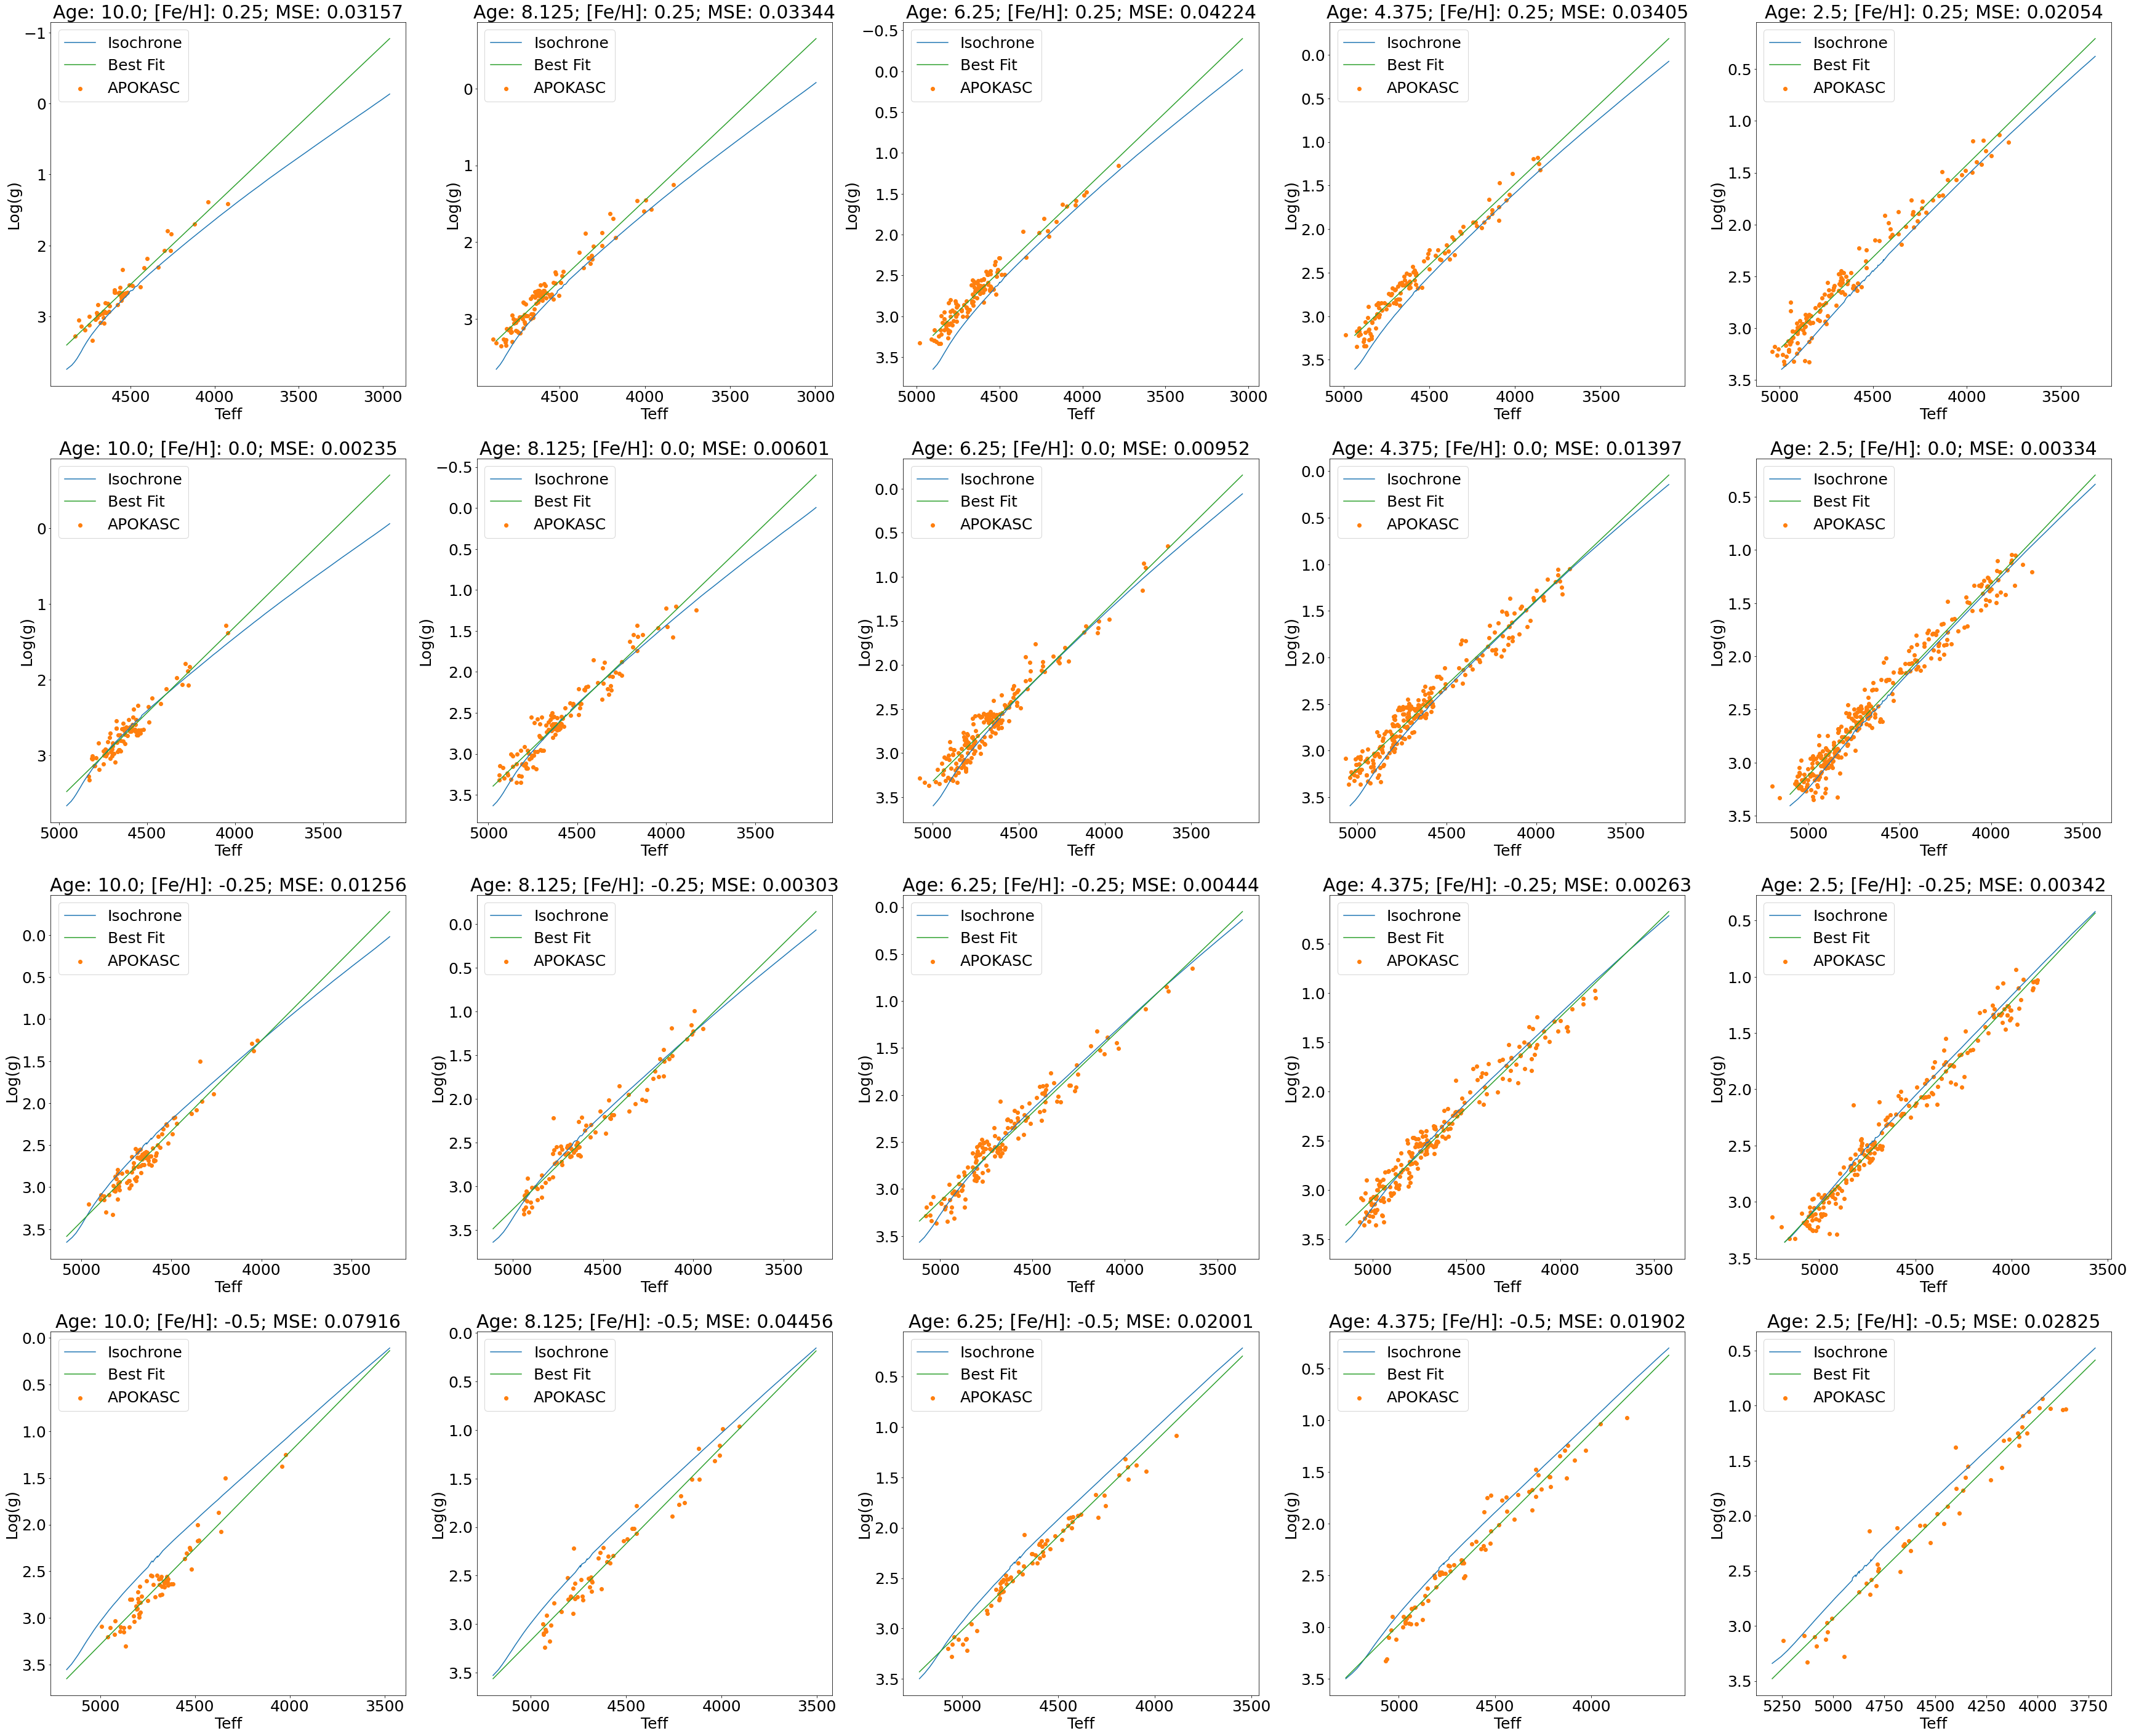

In [242]:
# fehs = np.array([0.25,0.0,-0.25,-0.5])
# ages = np.array([10,8.125,6.25,4.375,2.5])

# mse_arr = np.zeros((4,5))

# fig, ax = plt.subplots(4,5,figsize=[60,50])
# for i in range(4):
#     for j in range(5):
#         stars = k3dr17[np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
#                                 (k3dr17['Fe/H']<=fehs[i]+0.25)&(k3dr17['Fe/H']>=fehs[i]-0.25))]
        
#         stars = stars[np.argsort(stars['Teff'])]
        
#         stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]))&
#                                      (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
#         stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
#         line = (np.poly1d(robust.polyfit(stars['Teff'],stars['Logg'],1)))
#         line_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        
        
#         teffrange = np.where((stars_iso['logTe']>=closest(stars_iso['logTe'],np.log10(min(stars['Teff']))))&
#                              (stars_iso['logTe']<=closest(stars_iso['logTe'],np.log10(max(stars['Teff'])))))
        
#         mse = (np.sum(np.square((stars_iso['logg']-line(10**stars_iso['logTe']))[teffrange]))/
#                len(np.squeeze(teffrange)))
#         mse_arr[i,j] = mse
        
#         ax[i,j].scatter(stars['Teff'],stars['Logg'],c='tab:orange',label='APOKASC')
#         ax[i,j].plot(10**stars_iso['logTe'],stars_iso['logg'],c='tab:blue',label='Isochrone')
        
#         ax[i,j].plot(line_xs,line(line_xs),c='tab:green',label='Best Fit')
        
#         ax[i,j].legend()
        
#         ax[i,j].invert_xaxis()
#         ax[i,j].invert_yaxis()
        
#         ax[i,j].set_title(r'Age: {}; [Fe/H]: {}; MSE: {:.5f}'.format(ages[j],fehs[i],mse))
        
#         ax[i,j].set_xlabel(r'Teff')
#         ax[i,j].set_ylabel(r'Log(g)')
        
# # plt.suptitle(r'Without Salaris Correction')
# plt.savefig('../plots/isochrone_compare.pdf',dpi=300,bbox_inches='tight')
# plt.show()

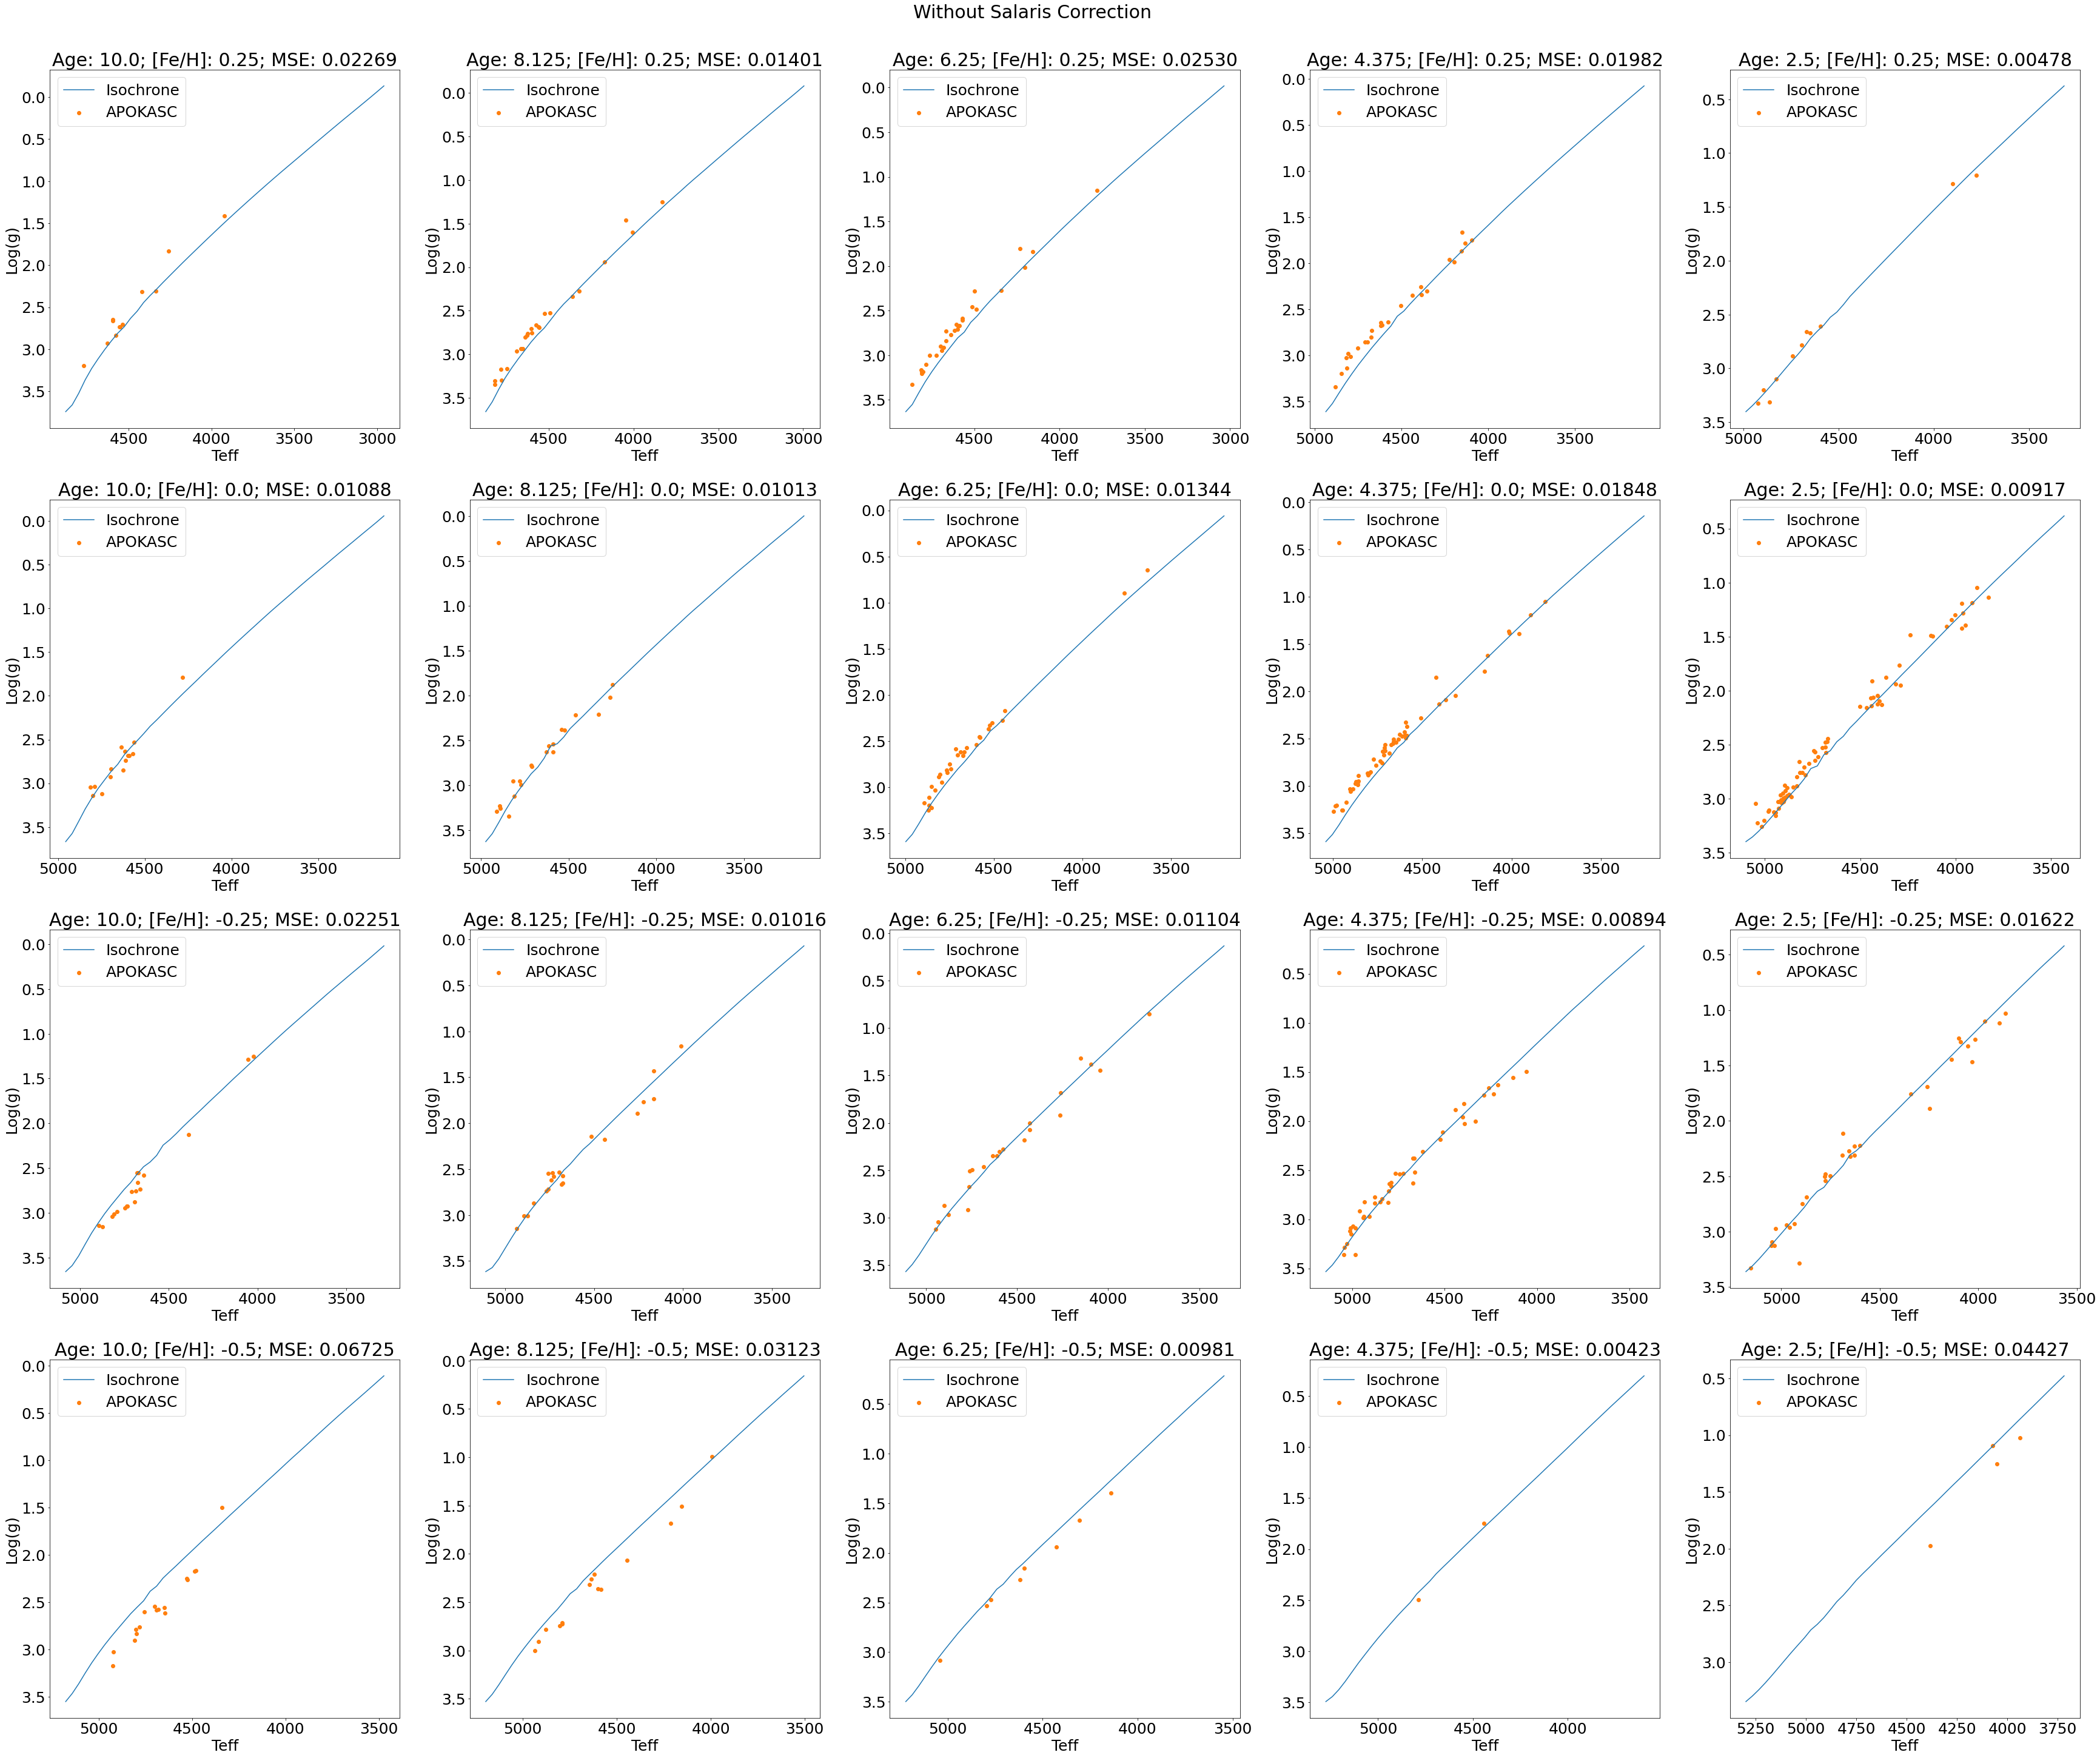

In [314]:
fehs = np.array([0.25,0.0,-0.25,-0.5])
ages = np.array([10,8.125,6.25,4.375,2.5])

fig, ax = plt.subplots(4,5,figsize=[60,50])
for i in range(4):
    for j in range(5):
        
        stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
                                (k3dr17['Fe/H']<=fehs[i]+0.05)&(k3dr17['Fe/H']>=fehs[i]-0.05))
        
        stars = k3dr17[stars_select]
        
        salcorr = 0 #np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
        stars = stars[np.argsort(stars['Teff'])]
        
        stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
                                     (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
        stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
        spl = IUS(10**stars_iso['logTe'][::2],stars_iso['logg'][::2])
        spl_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        
        mse = np.sum(np.square(stars['Logg']-spl(stars['Teff'])))/len(stars)
        mse_arr[i,j] = mse
        
        ax[i,j].scatter(stars['Teff'],stars['Logg'],c='tab:orange',label='APOKASC')
        
        ax[i,j].plot(spl_xs,spl(spl_xs),c='tab:blue',label='Isochrone')
        
        ax[i,j].legend()
        
        ax[i,j].invert_xaxis()
        ax[i,j].invert_yaxis()
        
        ax[i,j].set_title(r'Age: {}; [Fe/H]: {}; MSE: {:.5f}'.format(ages[j],fehs[i],mse))
        
        ax[i,j].set_xlabel(r'Teff')
        ax[i,j].set_ylabel(r'Log(g)')
        
plt.suptitle(r'Without Salaris Correction',y=0.91)
plt.savefig('../plots/isochrone_compare.pdf',dpi=300,bbox_inches='tight')
plt.show()

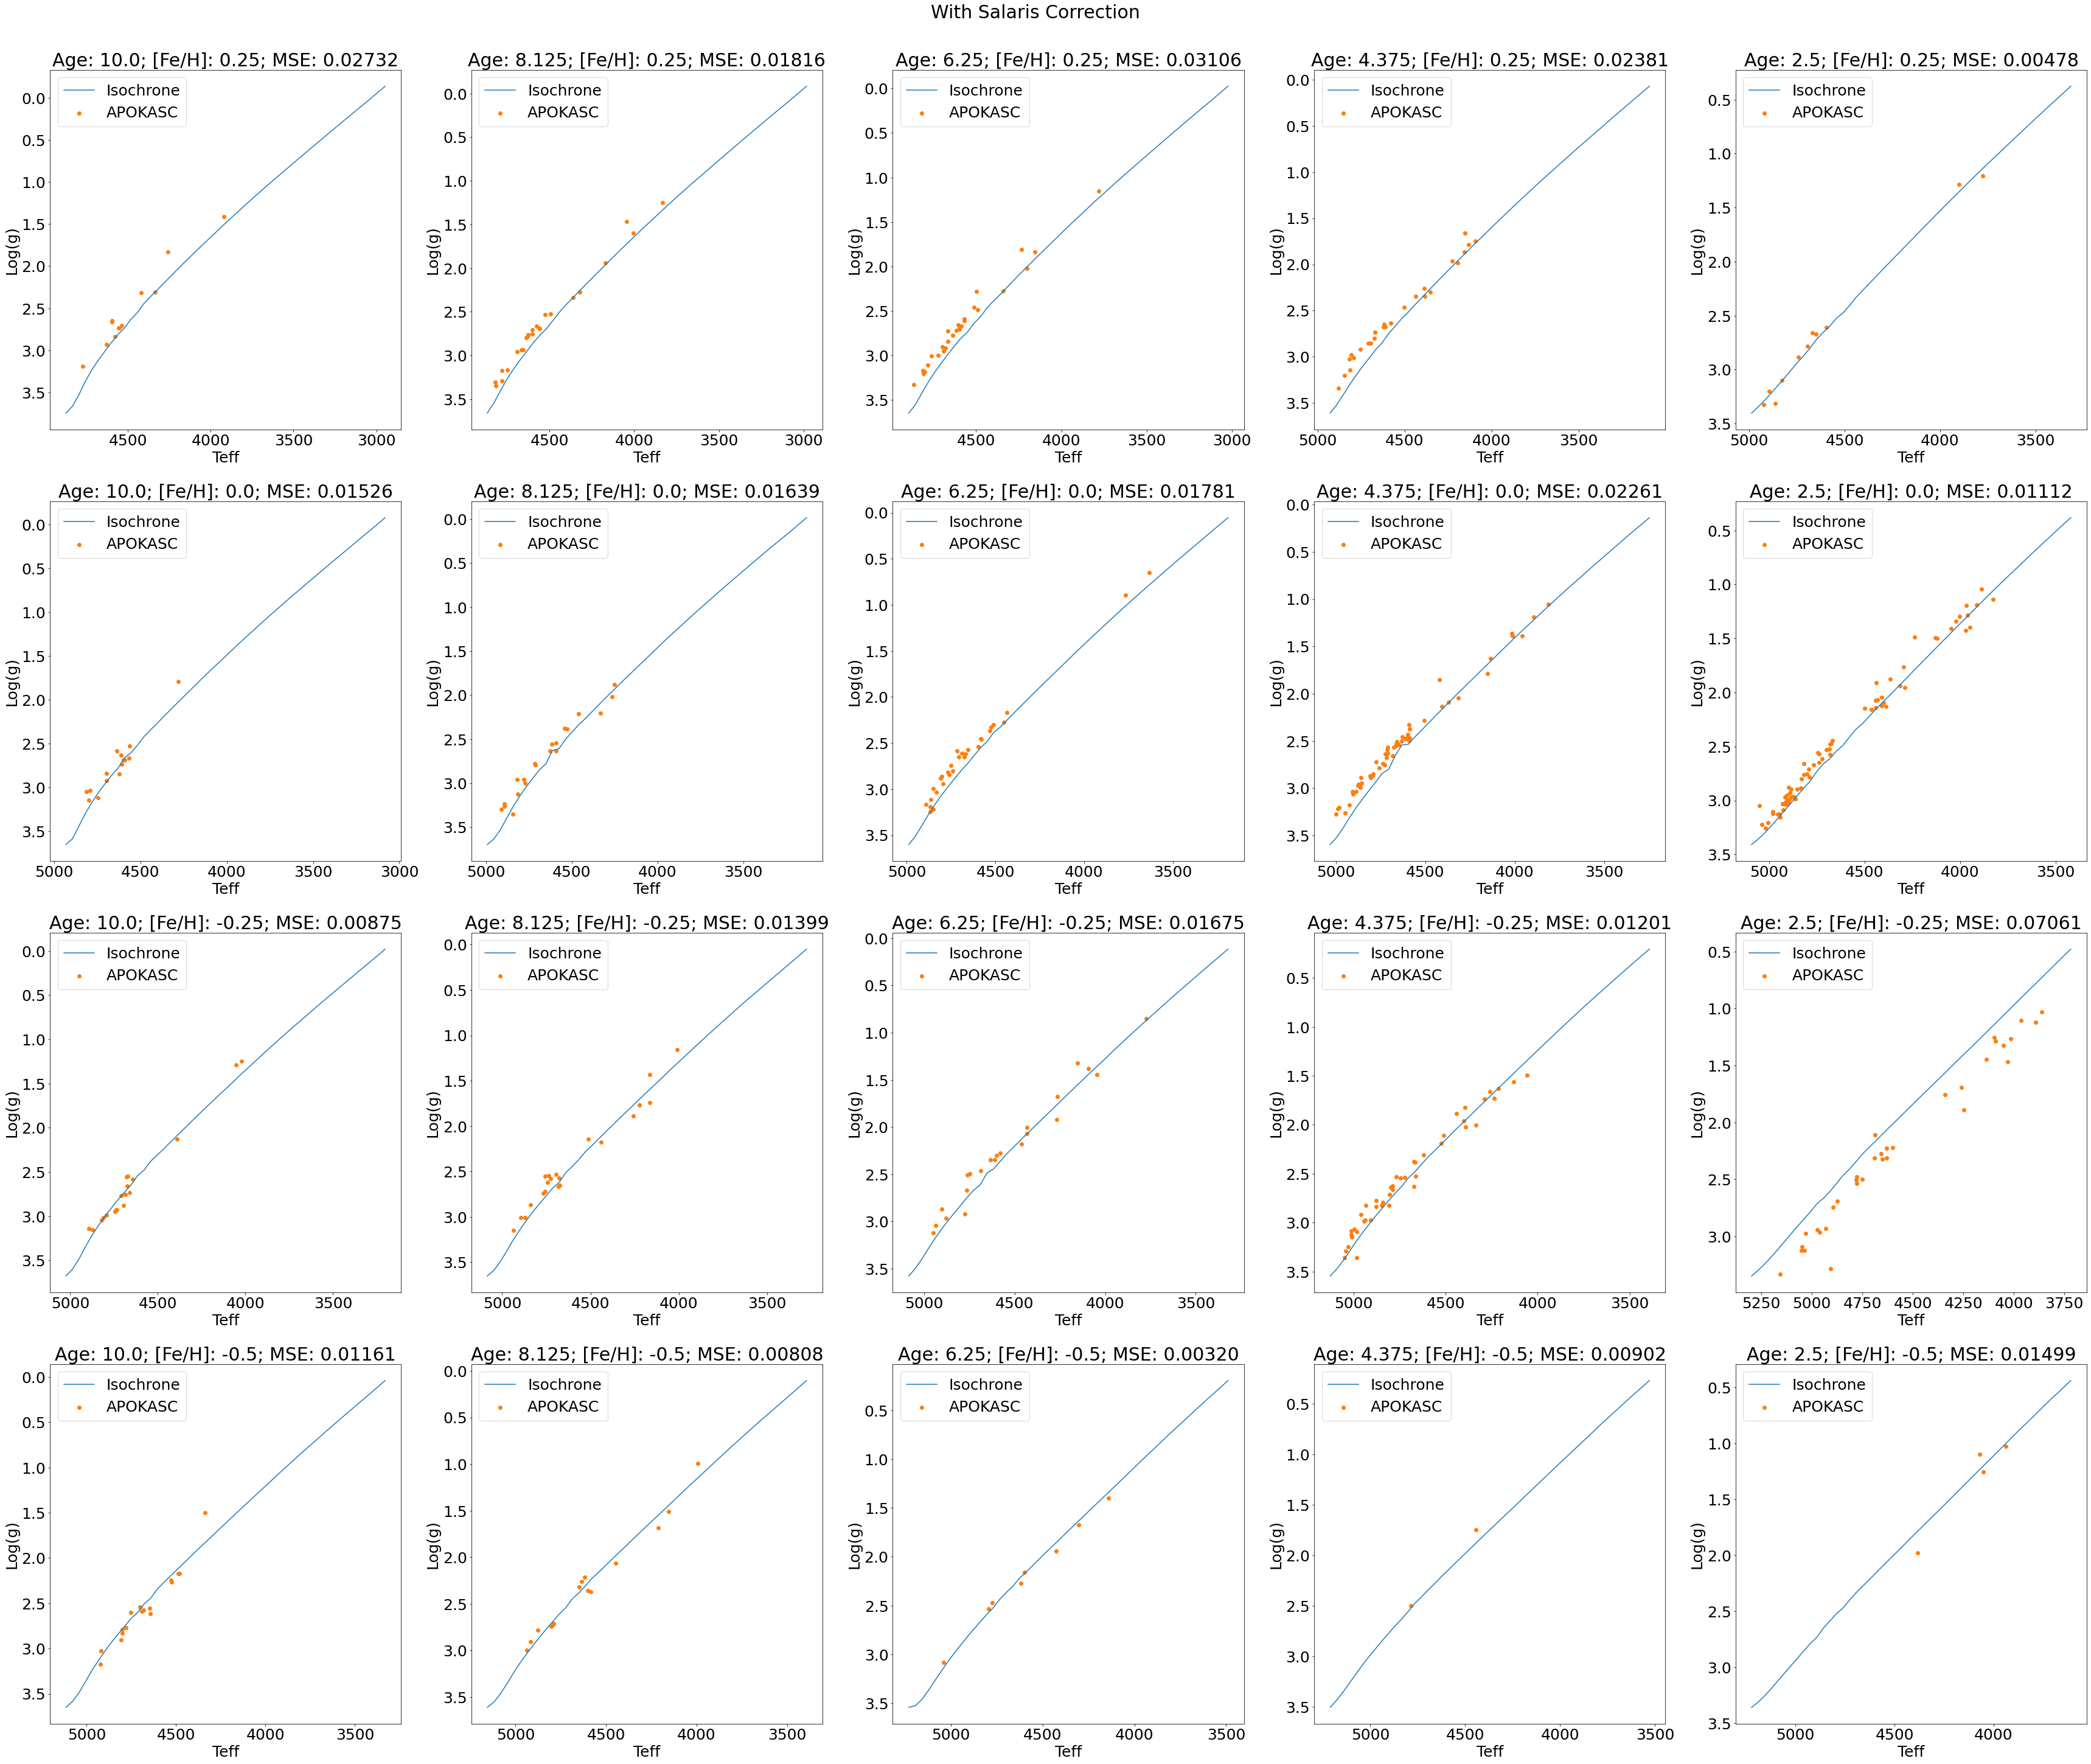

In [315]:
fehs = np.array([0.25,0.0,-0.25,-0.5])
ages = np.array([10,8.125,6.25,4.375,2.5])

fig, ax = plt.subplots(4,5,figsize=[60,50])
for i in range(4):
    for j in range(5):
        
        stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
                                (k3dr17['Fe/H']<=fehs[i]+0.05)&(k3dr17['Fe/H']>=fehs[i]-0.05))
        
        stars = k3dr17[stars_select]
        
        salcorr = np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
        stars = stars[np.argsort(stars['Teff'])]
        
        stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
                                     (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
        stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
        spl = IUS(10**stars_iso['logTe'][::2],stars_iso['logg'][::2])
        spl_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        
        mse = np.sum(np.square(stars['Logg']-spl(stars['Teff'])))/len(stars)
        mse_arr[i,j] = mse
        
        ax[i,j].scatter(stars['Teff'],stars['Logg'],c='tab:orange',label='APOKASC')
        
        ax[i,j].plot(spl_xs,spl(spl_xs),c='tab:blue',label='Isochrone')
        
        ax[i,j].legend()
        
        ax[i,j].invert_xaxis()
        ax[i,j].invert_yaxis()
        
        ax[i,j].set_title(r'Age: {}; [Fe/H]: {}; MSE: {:.5f}'.format(ages[j],fehs[i],mse))
        
        ax[i,j].set_xlabel(r'Teff')
        ax[i,j].set_ylabel(r'Log(g)')
        
plt.suptitle(r'With Salaris Correction',y=0.91)
plt.savefig('../plots/isochrone_compare_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

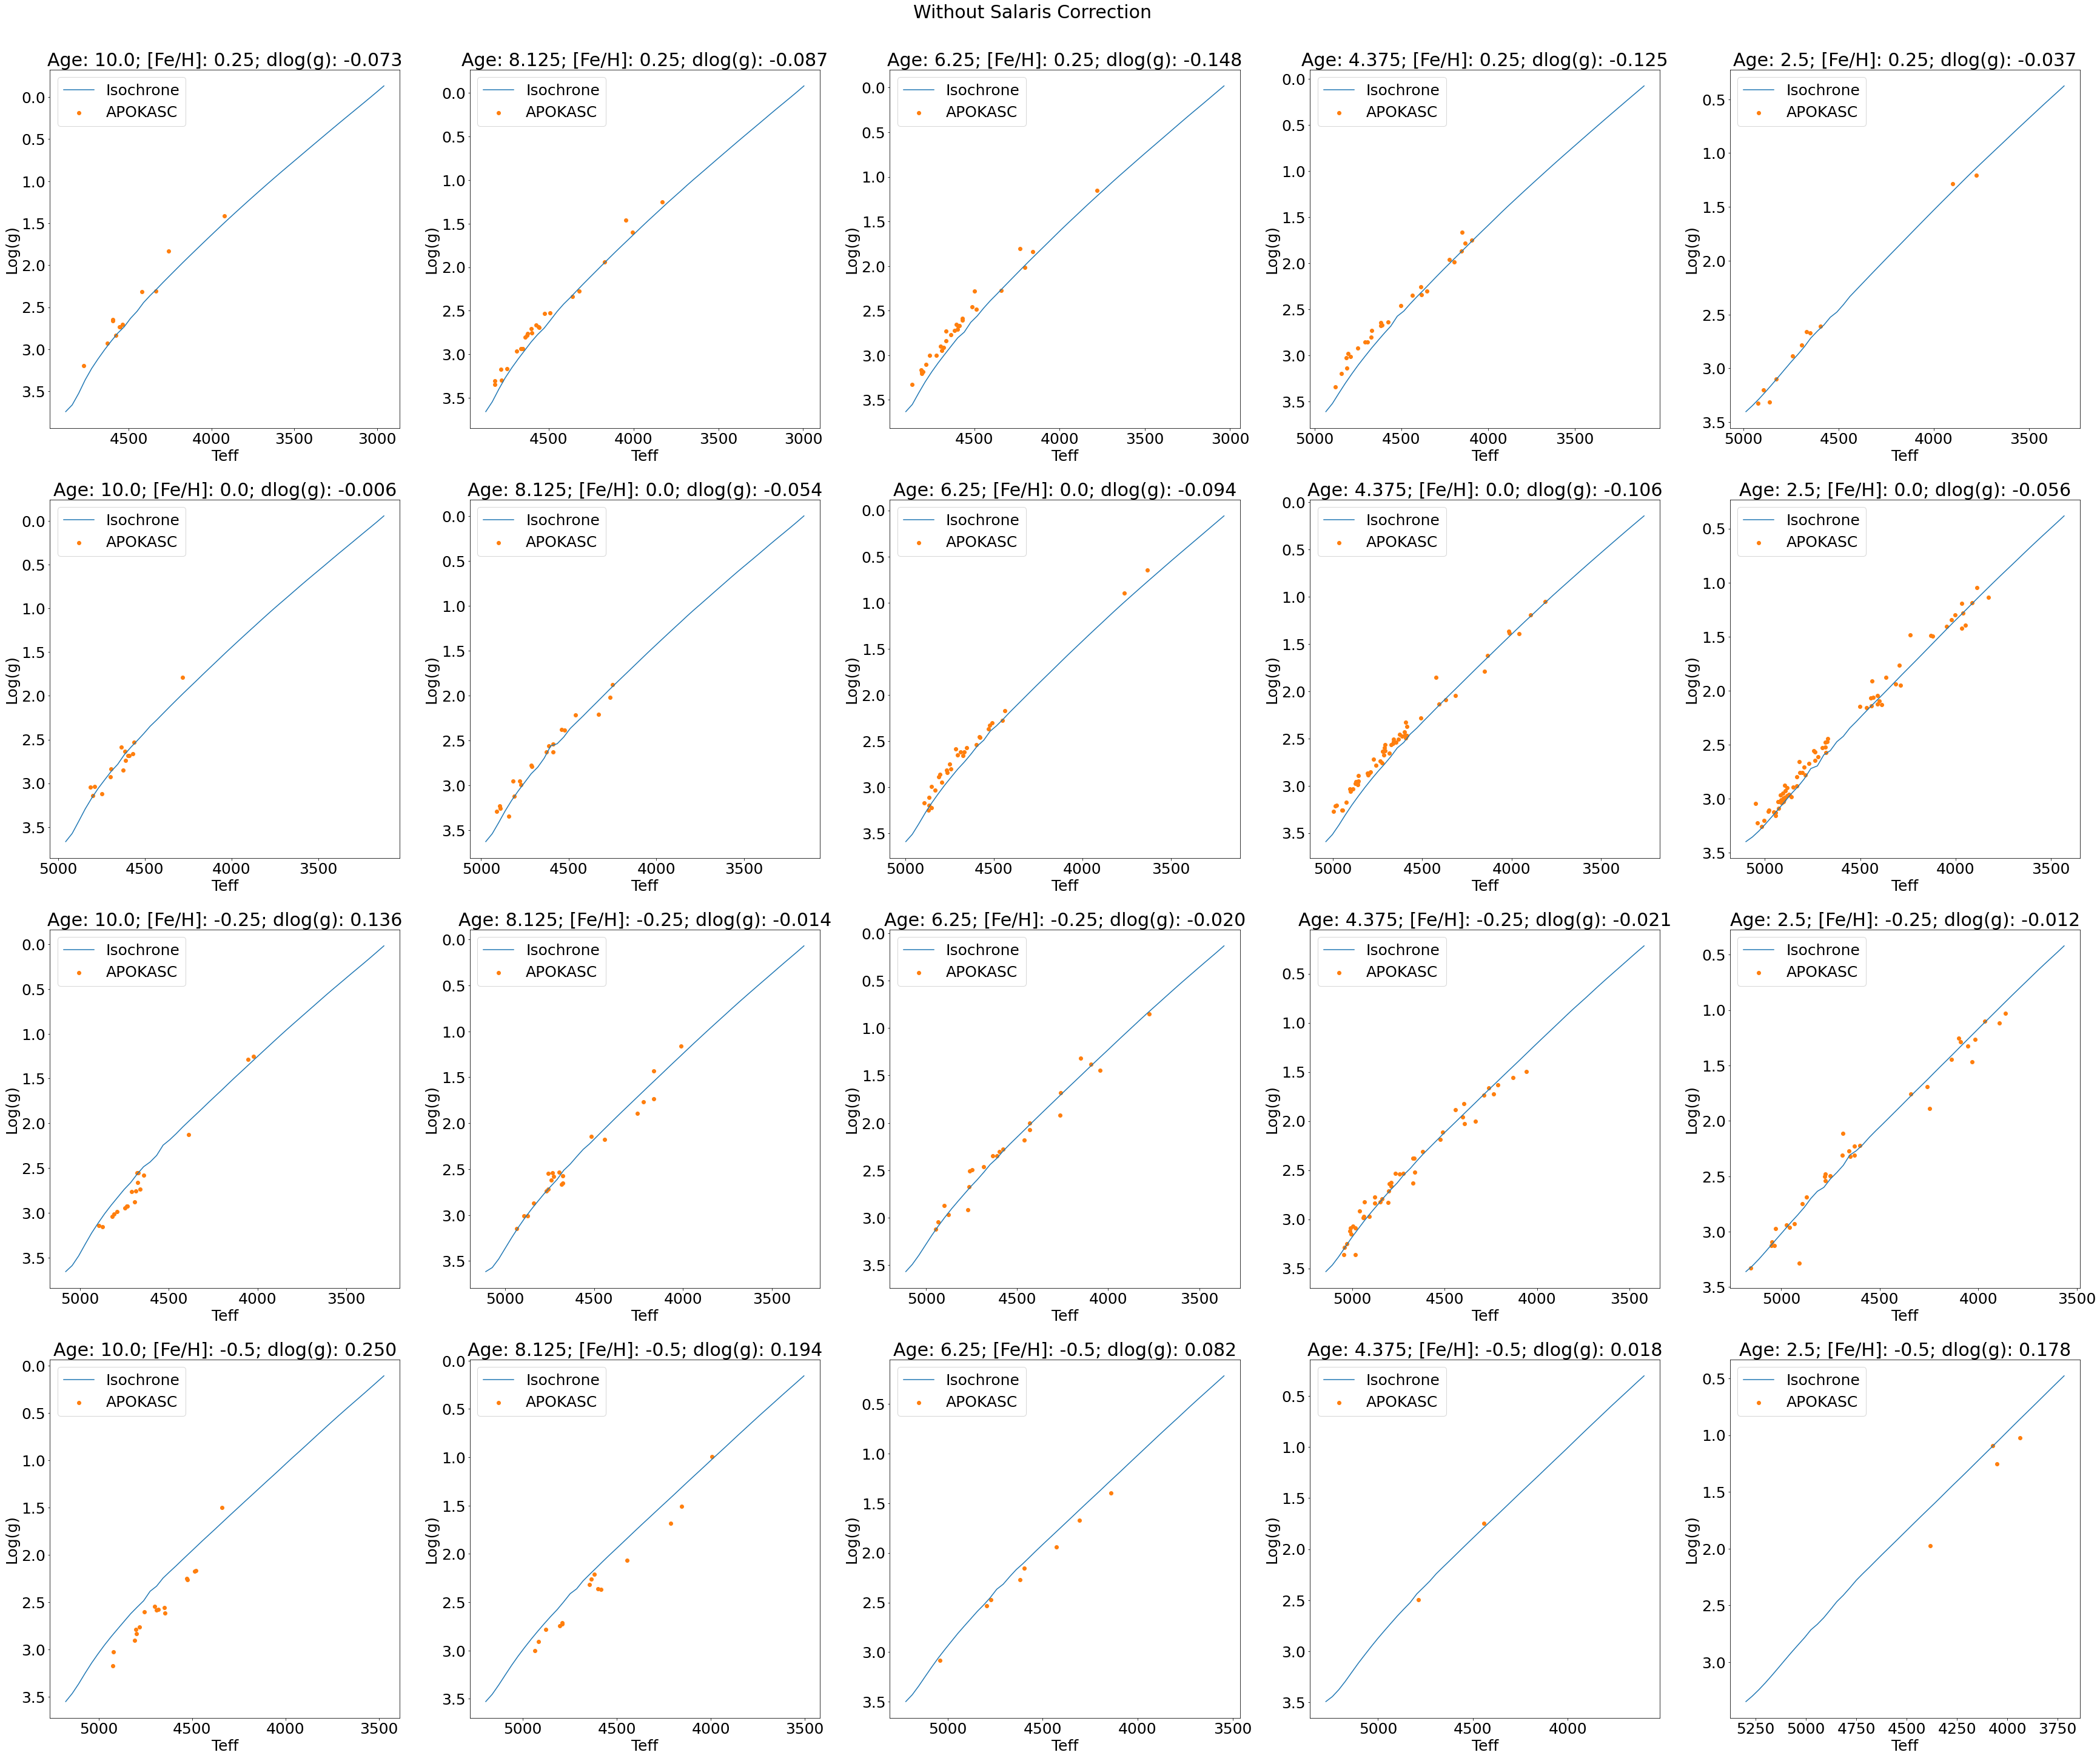

In [322]:
fehs = np.array([0.25,0.0,-0.25,-0.5])
ages = np.array([10,8.125,6.25,4.375,2.5])

dlogg_arr = np.zeros((4,5))

fig, ax = plt.subplots(4,5,figsize=[60,50])
for i in range(4):
    for j in range(5):
        
        stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
                                (k3dr17['Fe/H']<=fehs[i]+0.05)&(k3dr17['Fe/H']>=fehs[i]-0.05))
        
        stars = k3dr17[stars_select]
        
        salcorr = 0 #np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
        stars = stars[np.argsort(stars['Teff'])]
        
        stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
                                     (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
        stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
        spl = IUS(10**stars_iso['logTe'][::2],stars_iso['logg'][::2])
        spl_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        
        dlog = np.median(stars['Logg']-spl(stars['Teff']))
        dlogg_arr[i,j] = dlog
        
        ax[i,j].scatter(stars['Teff'],stars['Logg'],c='tab:orange',label='APOKASC')
        
        ax[i,j].plot(spl_xs,spl(spl_xs),c='tab:blue',label='Isochrone')
        
        ax[i,j].legend()
        
        ax[i,j].invert_xaxis()
        ax[i,j].invert_yaxis()
        
        ax[i,j].set_title(r'Age: {}; [Fe/H]: {}; dlog(g): {:.3f}'.format(ages[j],fehs[i],dlog))
        
        ax[i,j].set_xlabel(r'Teff')
        ax[i,j].set_ylabel(r'Log(g)')
        
plt.suptitle(r'Without Salaris Correction',y=0.91)
plt.savefig('../plots/isochrone_compare_dlogg.pdf',dpi=300,bbox_inches='tight')
plt.show()

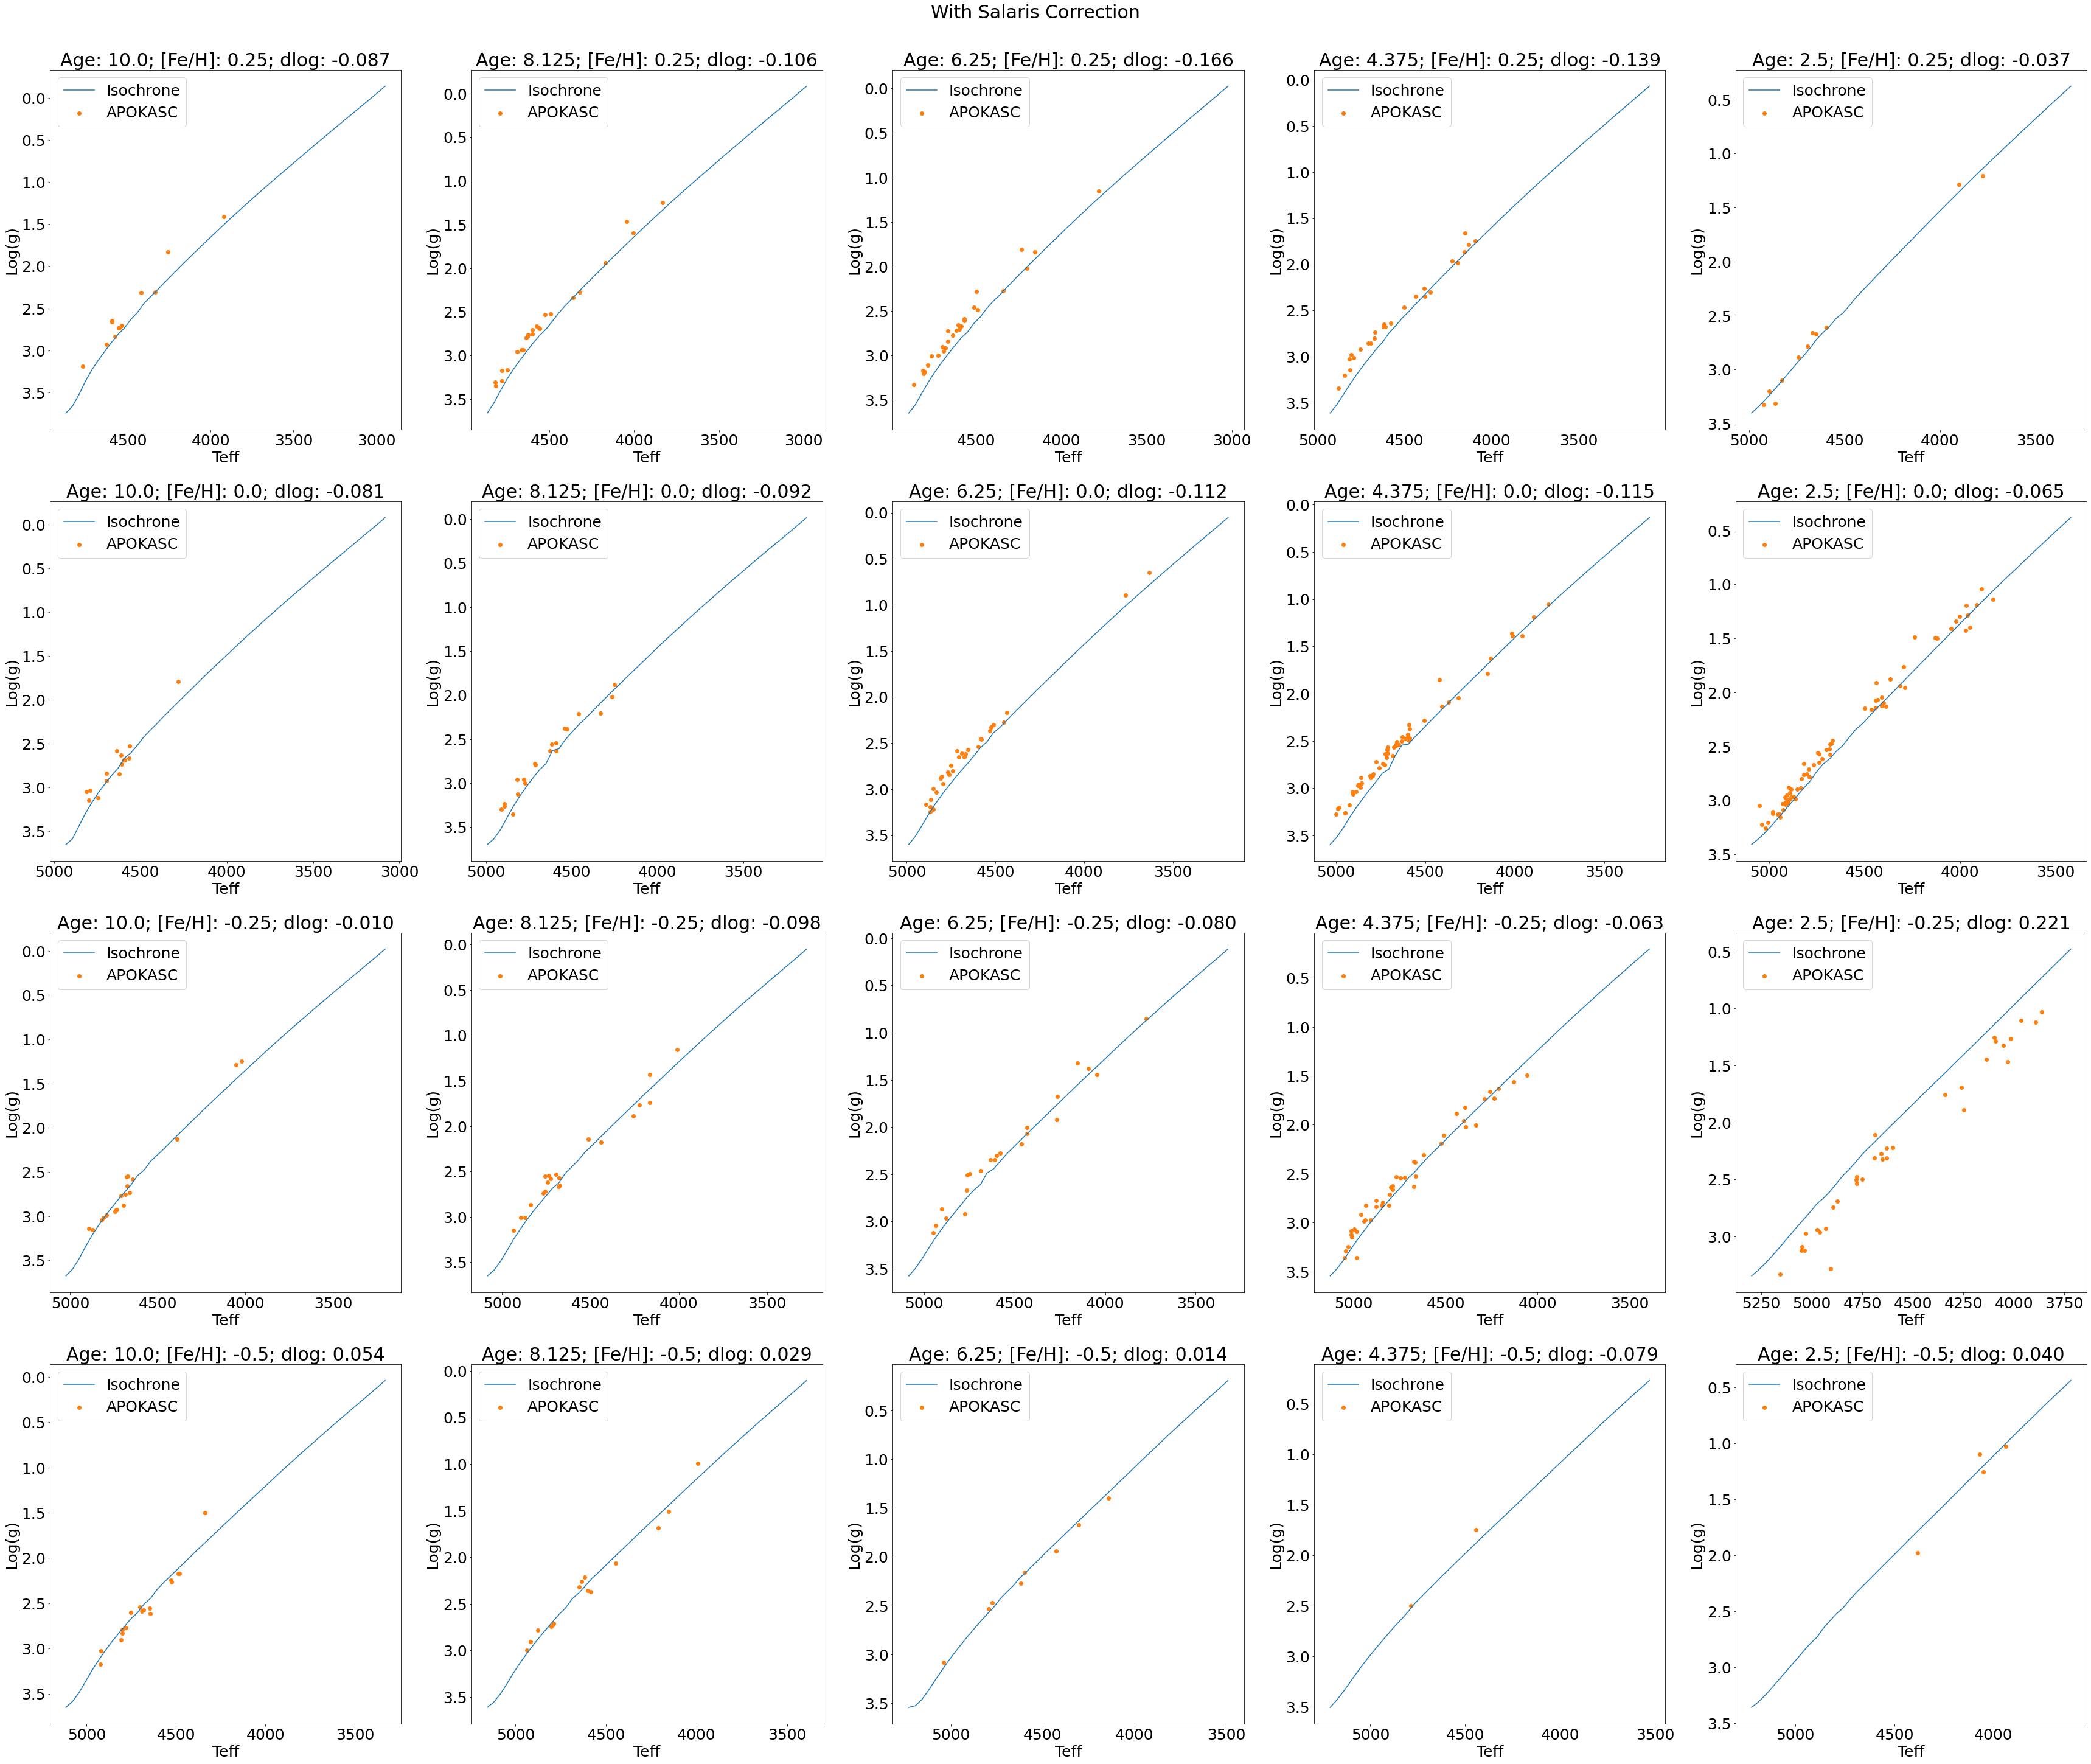

In [323]:
fehs = np.array([0.25,0.0,-0.25,-0.5])
ages = np.array([10,8.125,6.25,4.375,2.5])

dlogg_arr_salaris = np.zeros((4,5))

fig, ax = plt.subplots(4,5,figsize=[60,50])
for i in range(4):
    for j in range(5):
        
        stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
                                (k3dr17['Fe/H']<=fehs[i]+0.05)&(k3dr17['Fe/H']>=fehs[i]-0.05))
        
        stars = k3dr17[stars_select]
        
        salcorr = np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
        stars = stars[np.argsort(stars['Teff'])]
        
        stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
                                     (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
        stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
        spl = IUS(10**stars_iso['logTe'][::2],stars_iso['logg'][::2])
        spl_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        
        dlog = np.median(stars['Logg']-spl(stars['Teff']))
        dlogg_arr_salaris[i,j] = dlog 
        
        ax[i,j].scatter(stars['Teff'],stars['Logg'],c='tab:orange',label='APOKASC')
        
        ax[i,j].plot(spl_xs,spl(spl_xs),c='tab:blue',label='Isochrone')
        
        ax[i,j].legend()
        
        ax[i,j].invert_xaxis()
        ax[i,j].invert_yaxis()
        
        ax[i,j].set_title(r'Age: {}; [Fe/H]: {}; dlog: {:.3f}'.format(ages[j],fehs[i],dlog))
        
        ax[i,j].set_xlabel(r'Teff')
        ax[i,j].set_ylabel(r'Log(g)')
        
plt.suptitle(r'With Salaris Correction',y=0.91)
plt.savefig('../plots/isochrone_compare_dlogg_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

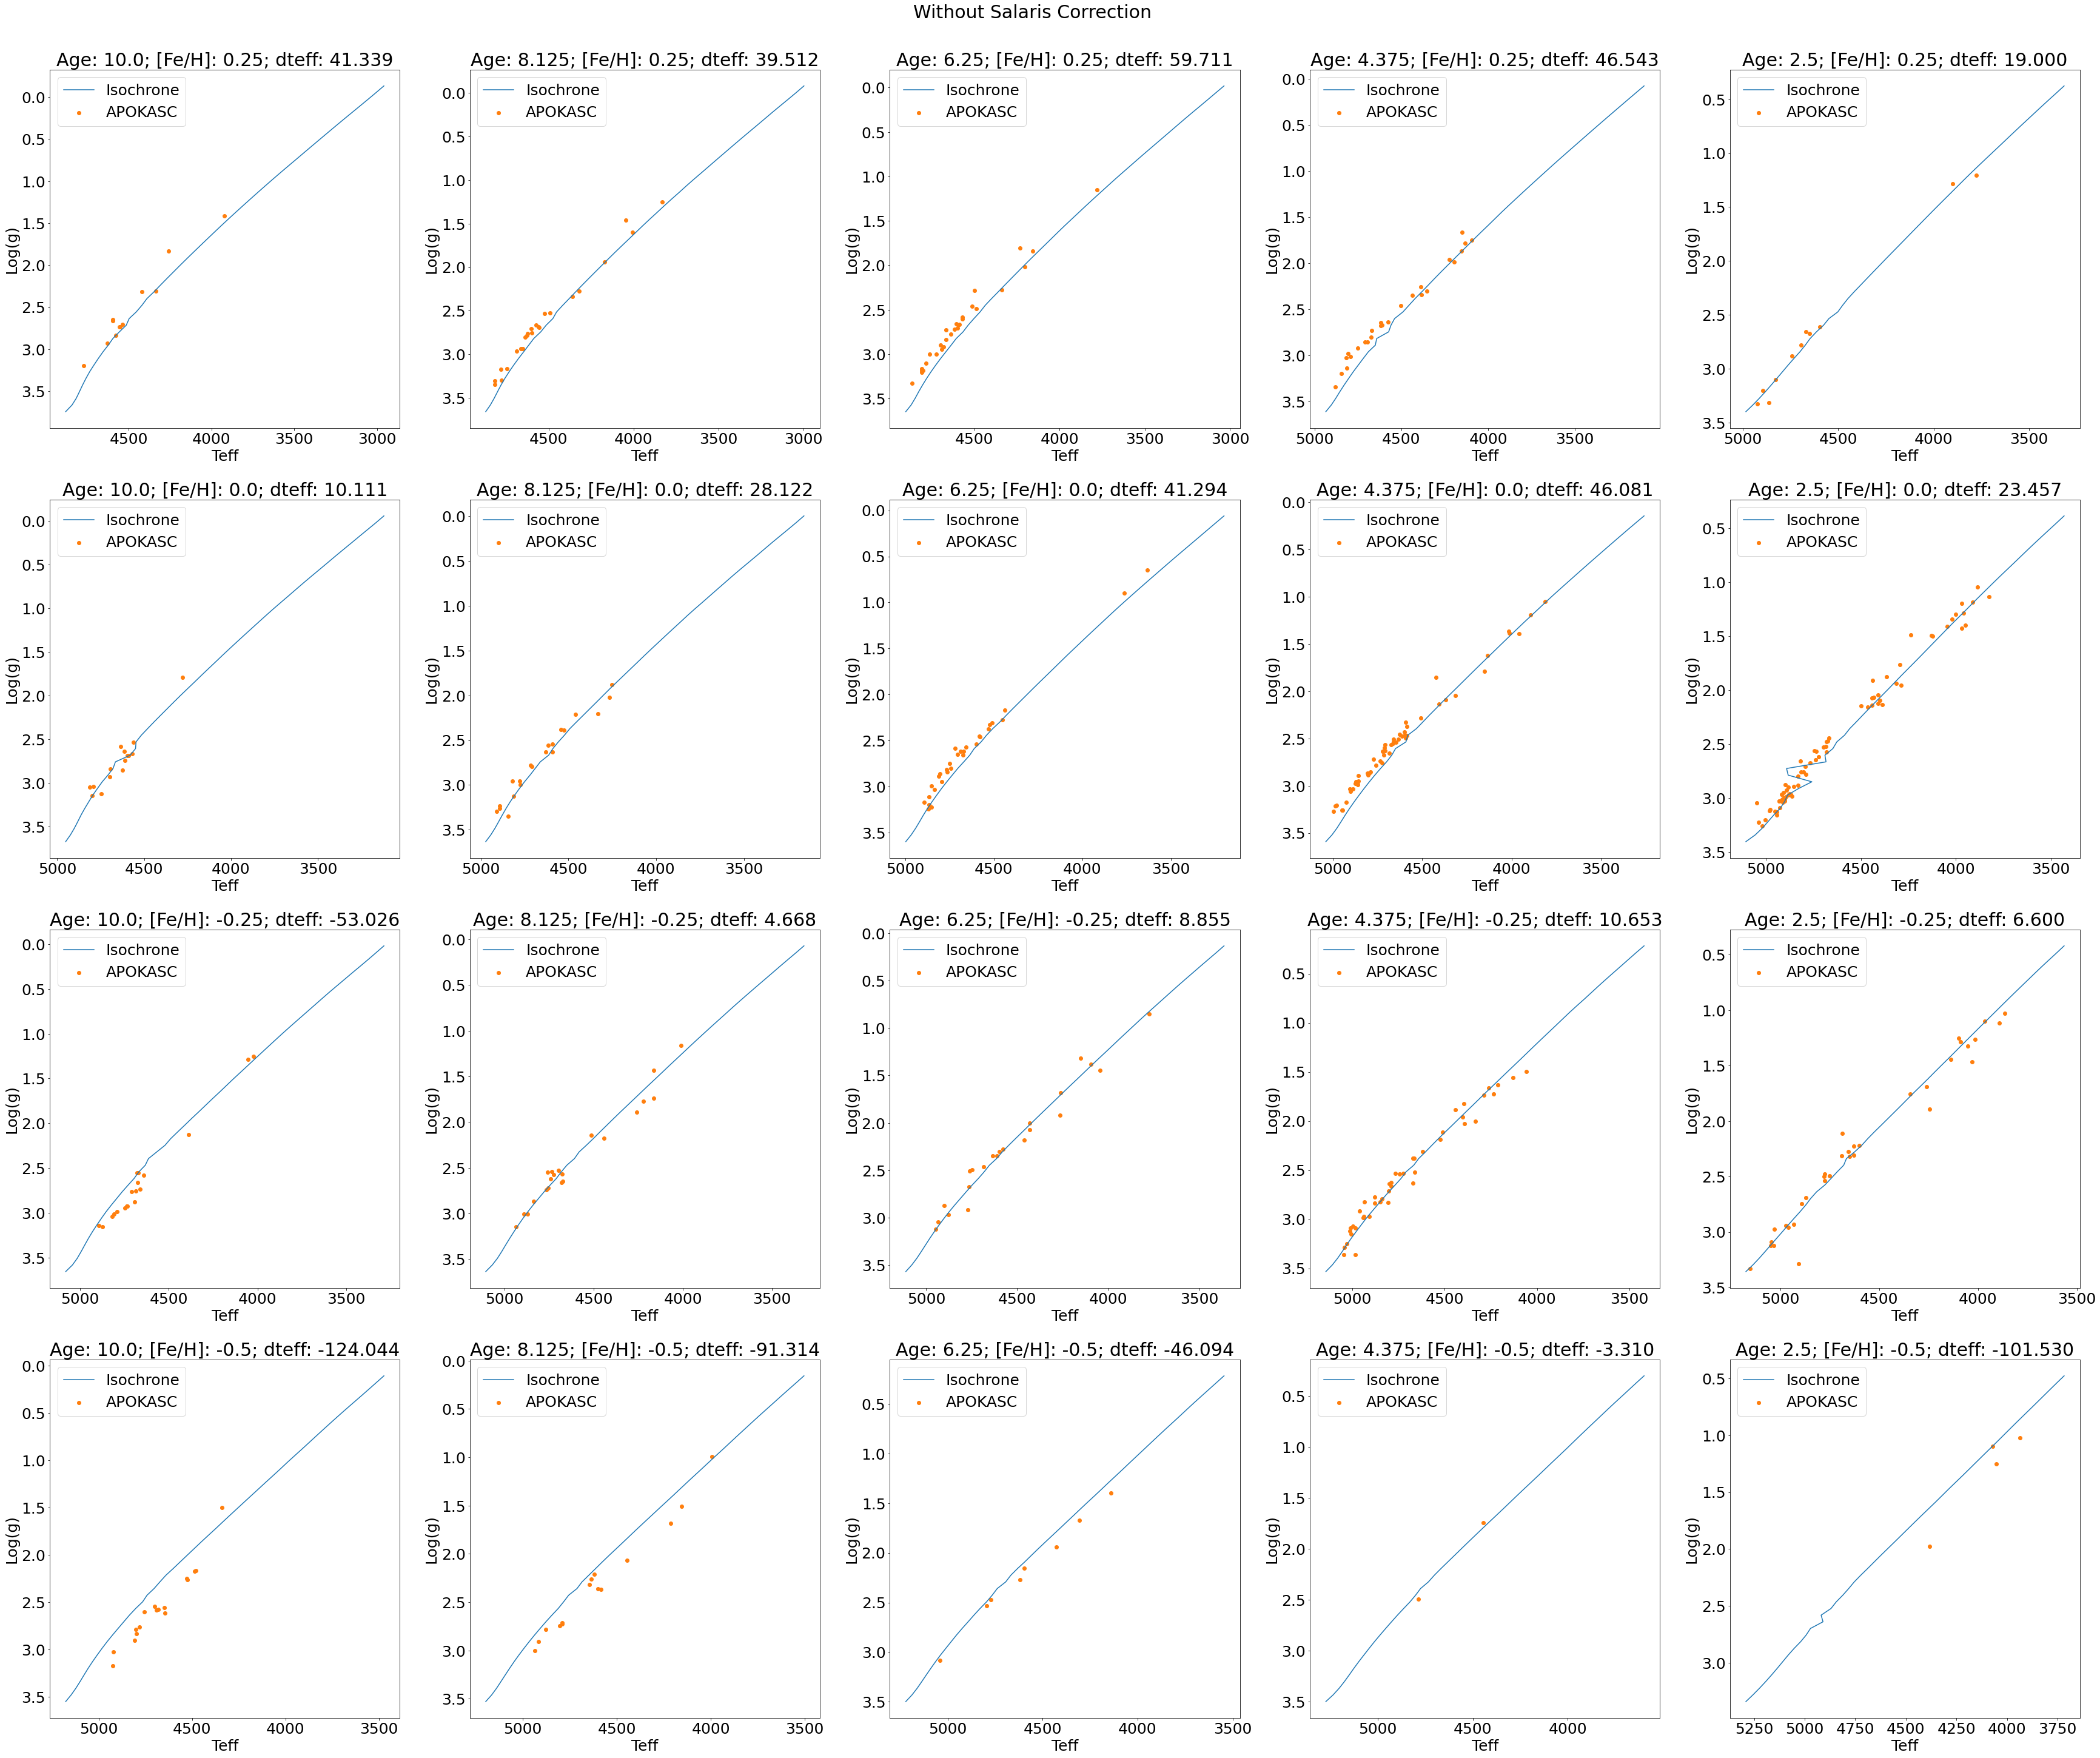

In [318]:
fehs = np.array([0.25,0.0,-0.25,-0.5])
ages = np.array([10,8.125,6.25,4.375,2.5])

feh_arr = np.zeros((4,5))
ages_arr = np.zeros((4,5))

dteff_arr = np.zeros((4,5))

fig, ax = plt.subplots(4,5,figsize=[60,50])
for i in range(4):
    for j in range(5):
        
        stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
                                (k3dr17['Fe/H']<=fehs[i]+0.05)&(k3dr17['Fe/H']>=fehs[i]-0.05))
        
        stars = k3dr17[stars_select]
        
        salcorr = 0 #np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
        stars = stars[np.argsort(stars['Teff'])]
        
        stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
                                     (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
        stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
        spl = IUS(stars_iso['logg'][::2][np.argsort(stars_iso['logg'][::2])],
                  10**stars_iso['logTe'][::2][np.argsort(stars_iso['logg'][::2])])
        
        spl_xs = np.linspace(min(stars_iso['logg']),max(stars_iso['logg']))
        
        dteff = np.median(stars['Teff']-spl(stars['Logg']))
        dteff_arr[i,j] = dteff
        
        feh_arr[i,j] = fehs[i]
        ages_arr[i,j] = ages[j]
        
        ax[i,j].scatter(stars['Teff'],stars['Logg'],c='tab:orange',label='APOKASC')
        
        ax[i,j].plot(spl(spl_xs),spl_xs,c='tab:blue',label='Isochrone')
        
        ax[i,j].legend()
        
        ax[i,j].invert_xaxis()
        ax[i,j].invert_yaxis()
        
        ax[i,j].set_title(r'Age: {}; [Fe/H]: {}; dteff: {:.3f}'.format(ages[j],fehs[i],dteff))
        
        ax[i,j].set_xlabel(r'Teff')
        ax[i,j].set_ylabel(r'Log(g)')
        
plt.suptitle(r'Without Salaris Correction',y=0.91)
plt.savefig('../plots/isochrone_compare_dteff.pdf',dpi=300,bbox_inches='tight')
plt.show()

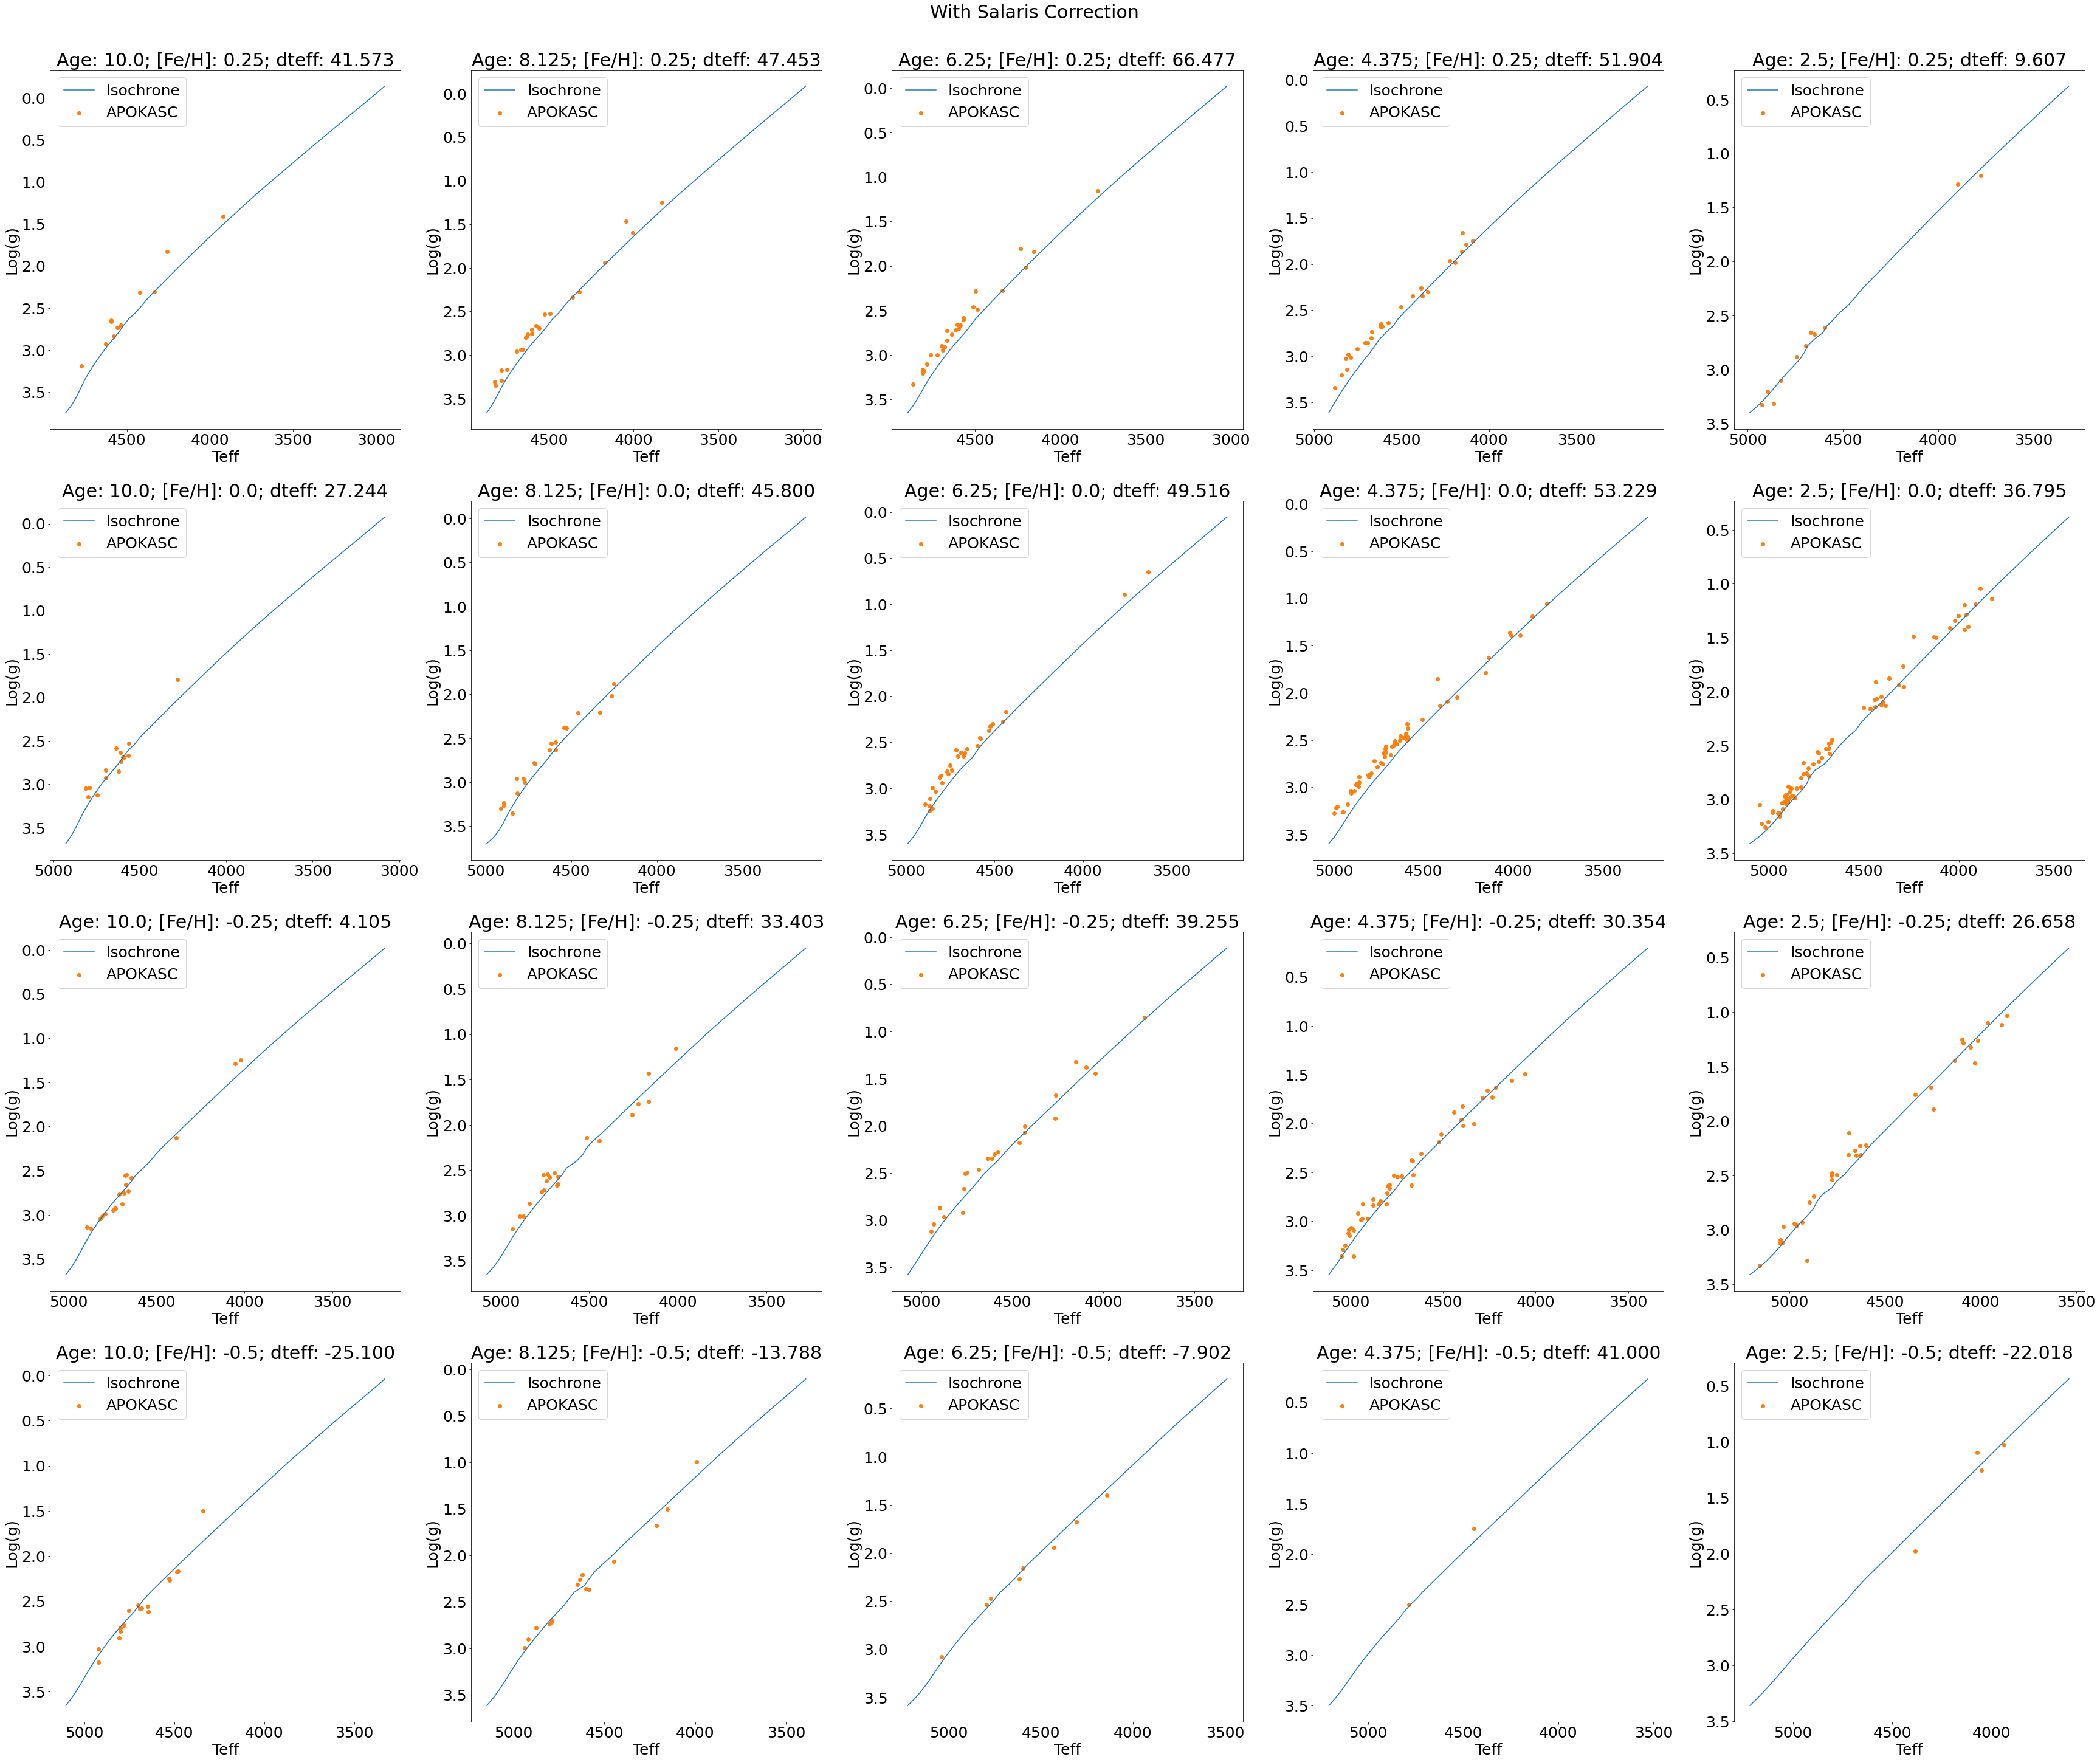

In [319]:
fehs = np.array([0.25,0.0,-0.25,-0.5])
ages = np.array([10,8.125,6.25,4.375,2.5])

feh_arr = np.zeros((4,5))
ages_arr = np.zeros((4,5))

alpha_arr = np.zeros((4,5))
sal_arr = np.zeros((4,5))

dteff_arr_salaris = np.zeros((4,5))

fig, ax = plt.subplots(4,5,figsize=[60,50])
for i in range(4):
    for j in range(5):
        
        stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
                                (k3dr17['Fe/H']<=fehs[i]+0.05)&(k3dr17['Fe/H']>=fehs[i]-0.05))
        
        stars = k3dr17[stars_select]
        
        salcorr = np.nanmedian(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        alpha_arr[i,j] = np.nanmedian(apoafe[stars_select])
        sal_arr[i,j] = fehs[i]+salcorr
        
        stars = stars[np.argsort(stars['Teff'])]
        
        stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
                                     (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
        stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
        spl = IUS(stars_iso['logg'][::3][np.argsort(stars_iso['logg'][::3])],
                  10**stars_iso['logTe'][::3][np.argsort(stars_iso['logg'][::3])])
        
        spl_xs = np.linspace(min(stars_iso['logg']),max(stars_iso['logg']))
        
        dteff = np.median(stars['Teff']-spl(stars['Logg']))
        dteff_arr_salaris[i,j] = dteff
        
        feh_arr[i,j] = fehs[i]
        ages_arr[i,j] = ages[j]
        
        ax[i,j].scatter(stars['Teff'],stars['Logg'],c='tab:orange',label='APOKASC')
        
        ax[i,j].plot(spl(spl_xs),spl_xs,c='tab:blue',label='Isochrone')
        
        ax[i,j].legend()
        
        ax[i,j].invert_xaxis()
        ax[i,j].invert_yaxis()
        
        ax[i,j].set_title(r'Age: {}; [Fe/H]: {}; dteff: {:.3f}'.format(ages[j],fehs[i],dteff))
        
        ax[i,j].set_xlabel(r'Teff')
        ax[i,j].set_ylabel(r'Log(g)')
        
plt.suptitle(r'With Salaris Correction',y=0.91)
plt.savefig('../plots/isochrone_compare_dteff_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [327]:
c1 = fits.Column(name='FE_H', array=feh_arr.ravel(), format='E')
c2 = fits.Column(name='FE_H_SALARIS', array=sal_arr.ravel(), format='E')
c3 = fits.Column(name='ALPHA_FE', array=alpha_arr.ravel(), format='E')
c4 = fits.Column(name='AGE', array=ages_arr.ravel(), format='E')
c5 = fits.Column(name='DTEFF', array=dteff_arr.ravel(), format='E')
c6 = fits.Column(name='DTEFF_SALARIS', array=dteff_arr_salaris.ravel(), format='E')
c7 = fits.Column(name='DLOGG', array=dlogg_arr.ravel(), format='E')
c8 = fits.Column(name='DLOGG_SALARIS', array=dlogg_arr_salaris.ravel(), format='E')

table_hdu = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7, c8])
# table_hdu.writeto('isochrone_shifts.fits')#,overwrite=True)

shift = Table(fits.getdata('isochrone_shifts.fits'))
shift.columns

<TableColumns names=('FE_H','FE_H_SALARIS','ALPHA_FE','AGE','DTEFF','DTEFF_SALARIS','DLOGG','DLOGG_SALARIS')>

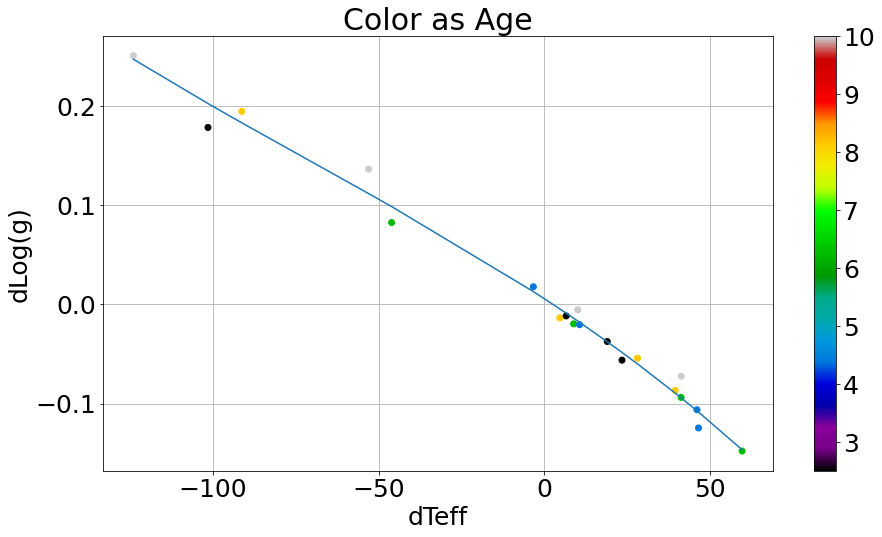

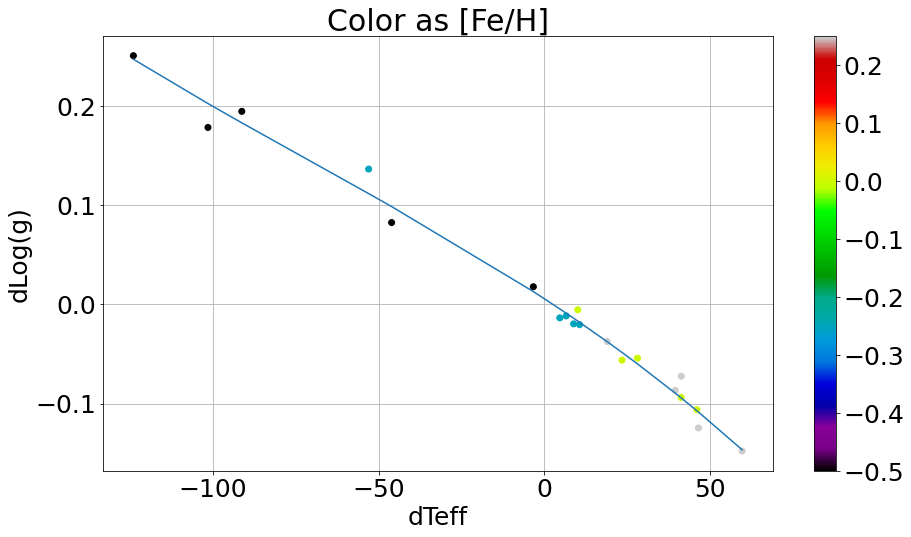

In [350]:
shiftpoly = np.poly1d(robust.polyfit(shift['DTEFF'],shift['DLOGG'],3))

###
plt.figure(figsize=[15,8])
plt.scatter(shift['DTEFF'],shift['DLOGG'],c=shift['AGE'],cmap='nipy_spectral')
plt.colorbar()

plt.plot(shift['DTEFF'][np.argsort(shift['DTEFF'])],shiftpoly(shift['DTEFF'][np.argsort(shift['DTEFF'])]))

plt.grid()
plt.title(r'Color as Age')
plt.xlabel(r'dTeff')
plt.ylabel(r'dLog(g)')
plt.savefig('../plots/shifts_age.png',bbox_inches='tight')
plt.show()

###
plt.figure(figsize=[15,8])
plt.scatter(shift['DTEFF'],shift['DLOGG'],c=shift['FE_H'],cmap='nipy_spectral')
plt.colorbar()

plt.plot(shift['DTEFF'][np.argsort(shift['DTEFF'])],shiftpoly(shift['DTEFF'][np.argsort(shift['DTEFF'])]))

plt.grid()
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'dTeff')
plt.ylabel(r'dLog(g)')
plt.savefig('../plots/shifts_feh.png',bbox_inches='tight')
plt.show()

In [351]:
dr16 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-r12-l33.fits.gz')

_, dr16_ind, k_ind = np.intersect1d(dr16['APOGEE_ID'],kdr17['APOGEE_ID'],return_indices=True)

kdr16 = dr16[dr16_ind]

In [354]:
np.where((kdr17['APOGEE_ID']==kdr16['APOGEE_ID'])==False)

(array([], dtype=int64),)

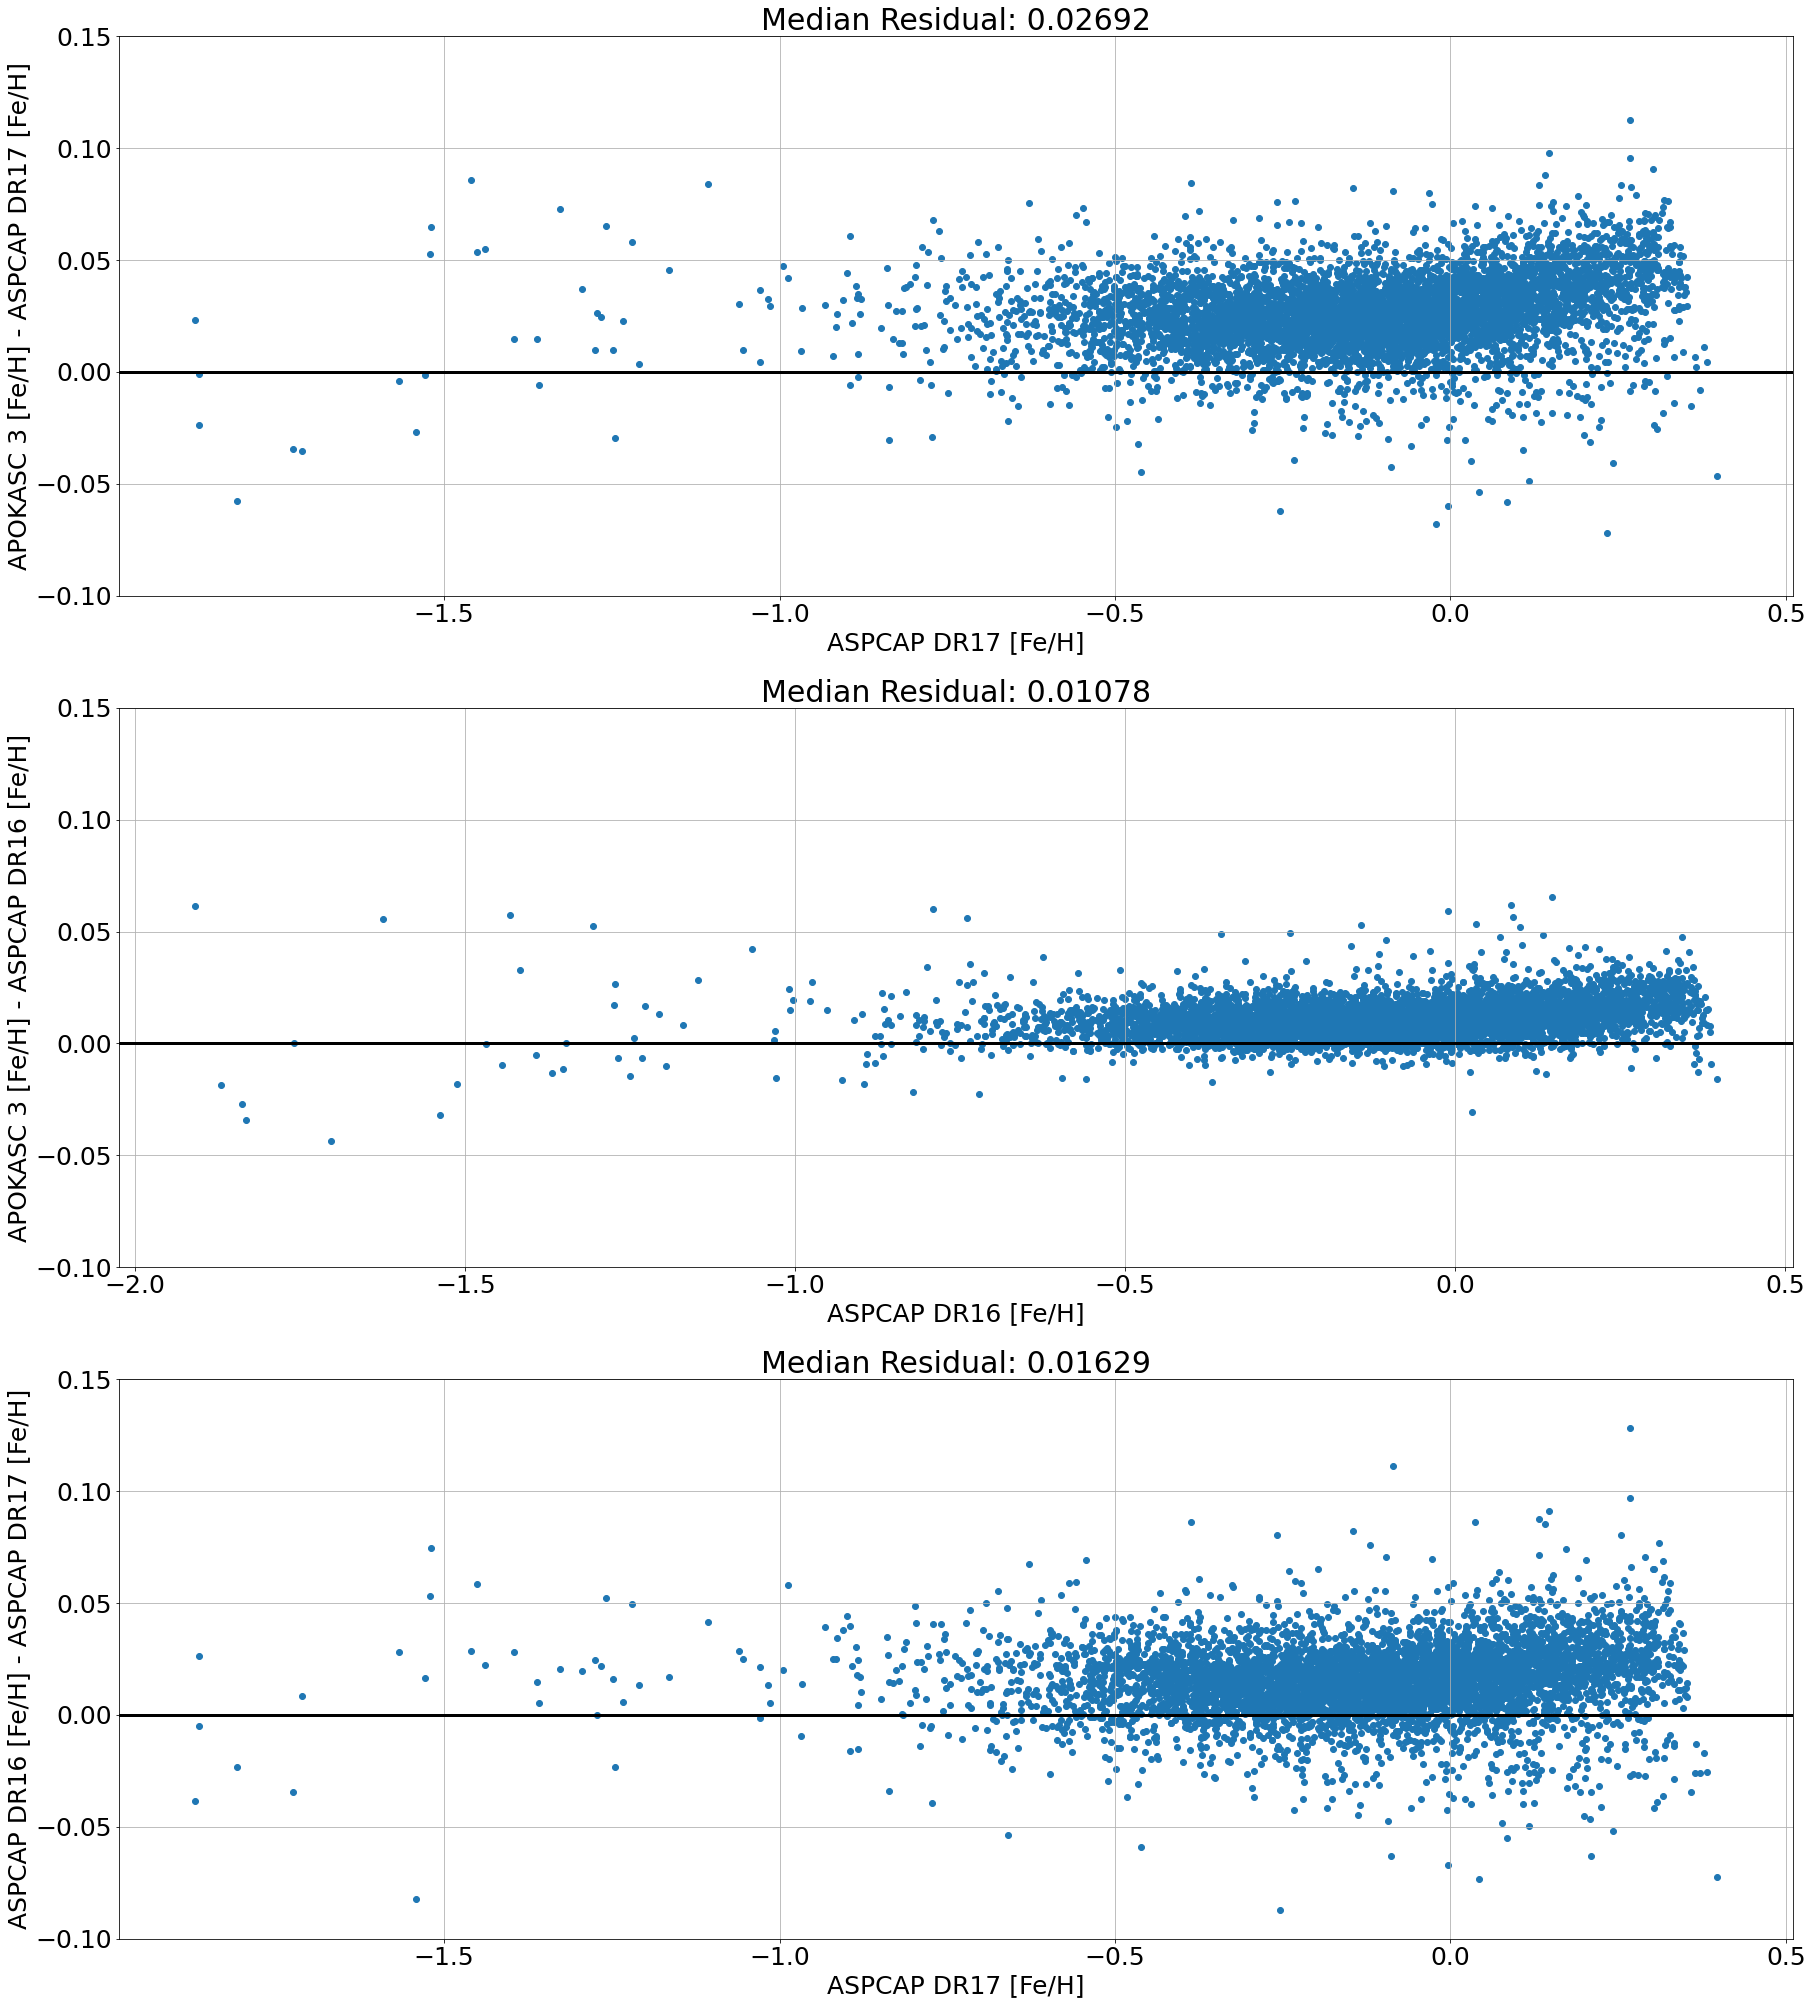

In [374]:
plt.figure(figsize=[30,35])

###
plt.subplot(311)
plt.scatter(kdr17['FE_H'],k3dr17['Fe/H']-kdr17['FE_H'])

plt.axhline(0.0,c='k',lw=3.0)

plt.title(r'Median Residual: {:.5f}'.format(np.nanmedian(k3dr17['Fe/H']-kdr17['FE_H'])))
plt.xlabel(r'ASPCAP DR17 [Fe/H]')
plt.ylabel(r'APOKASC 3 [Fe/H] - ASPCAP DR17 [Fe/H]')

plt.ylim(-0.1,0.15)
plt.grid()

###
plt.subplot(312)
plt.scatter(kdr16['FE_H'],k3dr17['Fe/H']-kdr16['FE_H'])

plt.axhline(0.0,c='k',lw=3.0)

plt.title(r'Median Residual: {:.5f}'.format(np.nanmedian(k3dr17['Fe/H']-kdr16['FE_H'])))
plt.xlabel(r'ASPCAP DR16 [Fe/H]')
plt.ylabel(r'APOKASC 3 [Fe/H] - ASPCAP DR16 [Fe/H]')

plt.ylim(-0.1,0.15)
plt.grid()

###
plt.subplot(313)
plt.scatter(kdr17['FE_H'],kdr16['FE_H']-kdr17['FE_H'])

plt.axhline(0.0,c='k',lw=3.0)

plt.title(r'Median Residual: {:.5f}'.format(np.nanmedian(kdr16['FE_H']-kdr17['FE_H'])))
plt.xlabel(r'ASPCAP DR17 [Fe/H]')
plt.ylabel(r'ASPCAP DR16 [Fe/H] - ASPCAP DR17 [Fe/H]')

plt.ylim(-0.1,0.15)
plt.grid()

plt.savefig('../plots/feh_resids.pdf',dpi=300,bbox_inches='tight')
plt.show()

# ###
# plt.subplot(414)
# plt.scatter(kdr16['FE_H'],kdr17['FE_H']-kdr16['FE_H'])

# plt.axhline(0.0,c='k',lw=3.0)

# plt.title(r'{:.5f}'.format(np.nanmedian(kdr16['FE_H']-kdr17['FE_H'])))
# plt.xlabel(r'ASPCAP DR16 [Fe/H]')
# plt.ylabel(r'ASPCAP DR16 [Fe/H] - ASPCAP DR17 [Fe/H]')

# plt.grid()
# plt.ylim(bottom=-0.1)

# Absolute Magnitude

In [271]:
massive.columns

<TableColumns names=('index','MH','Mass','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag')>

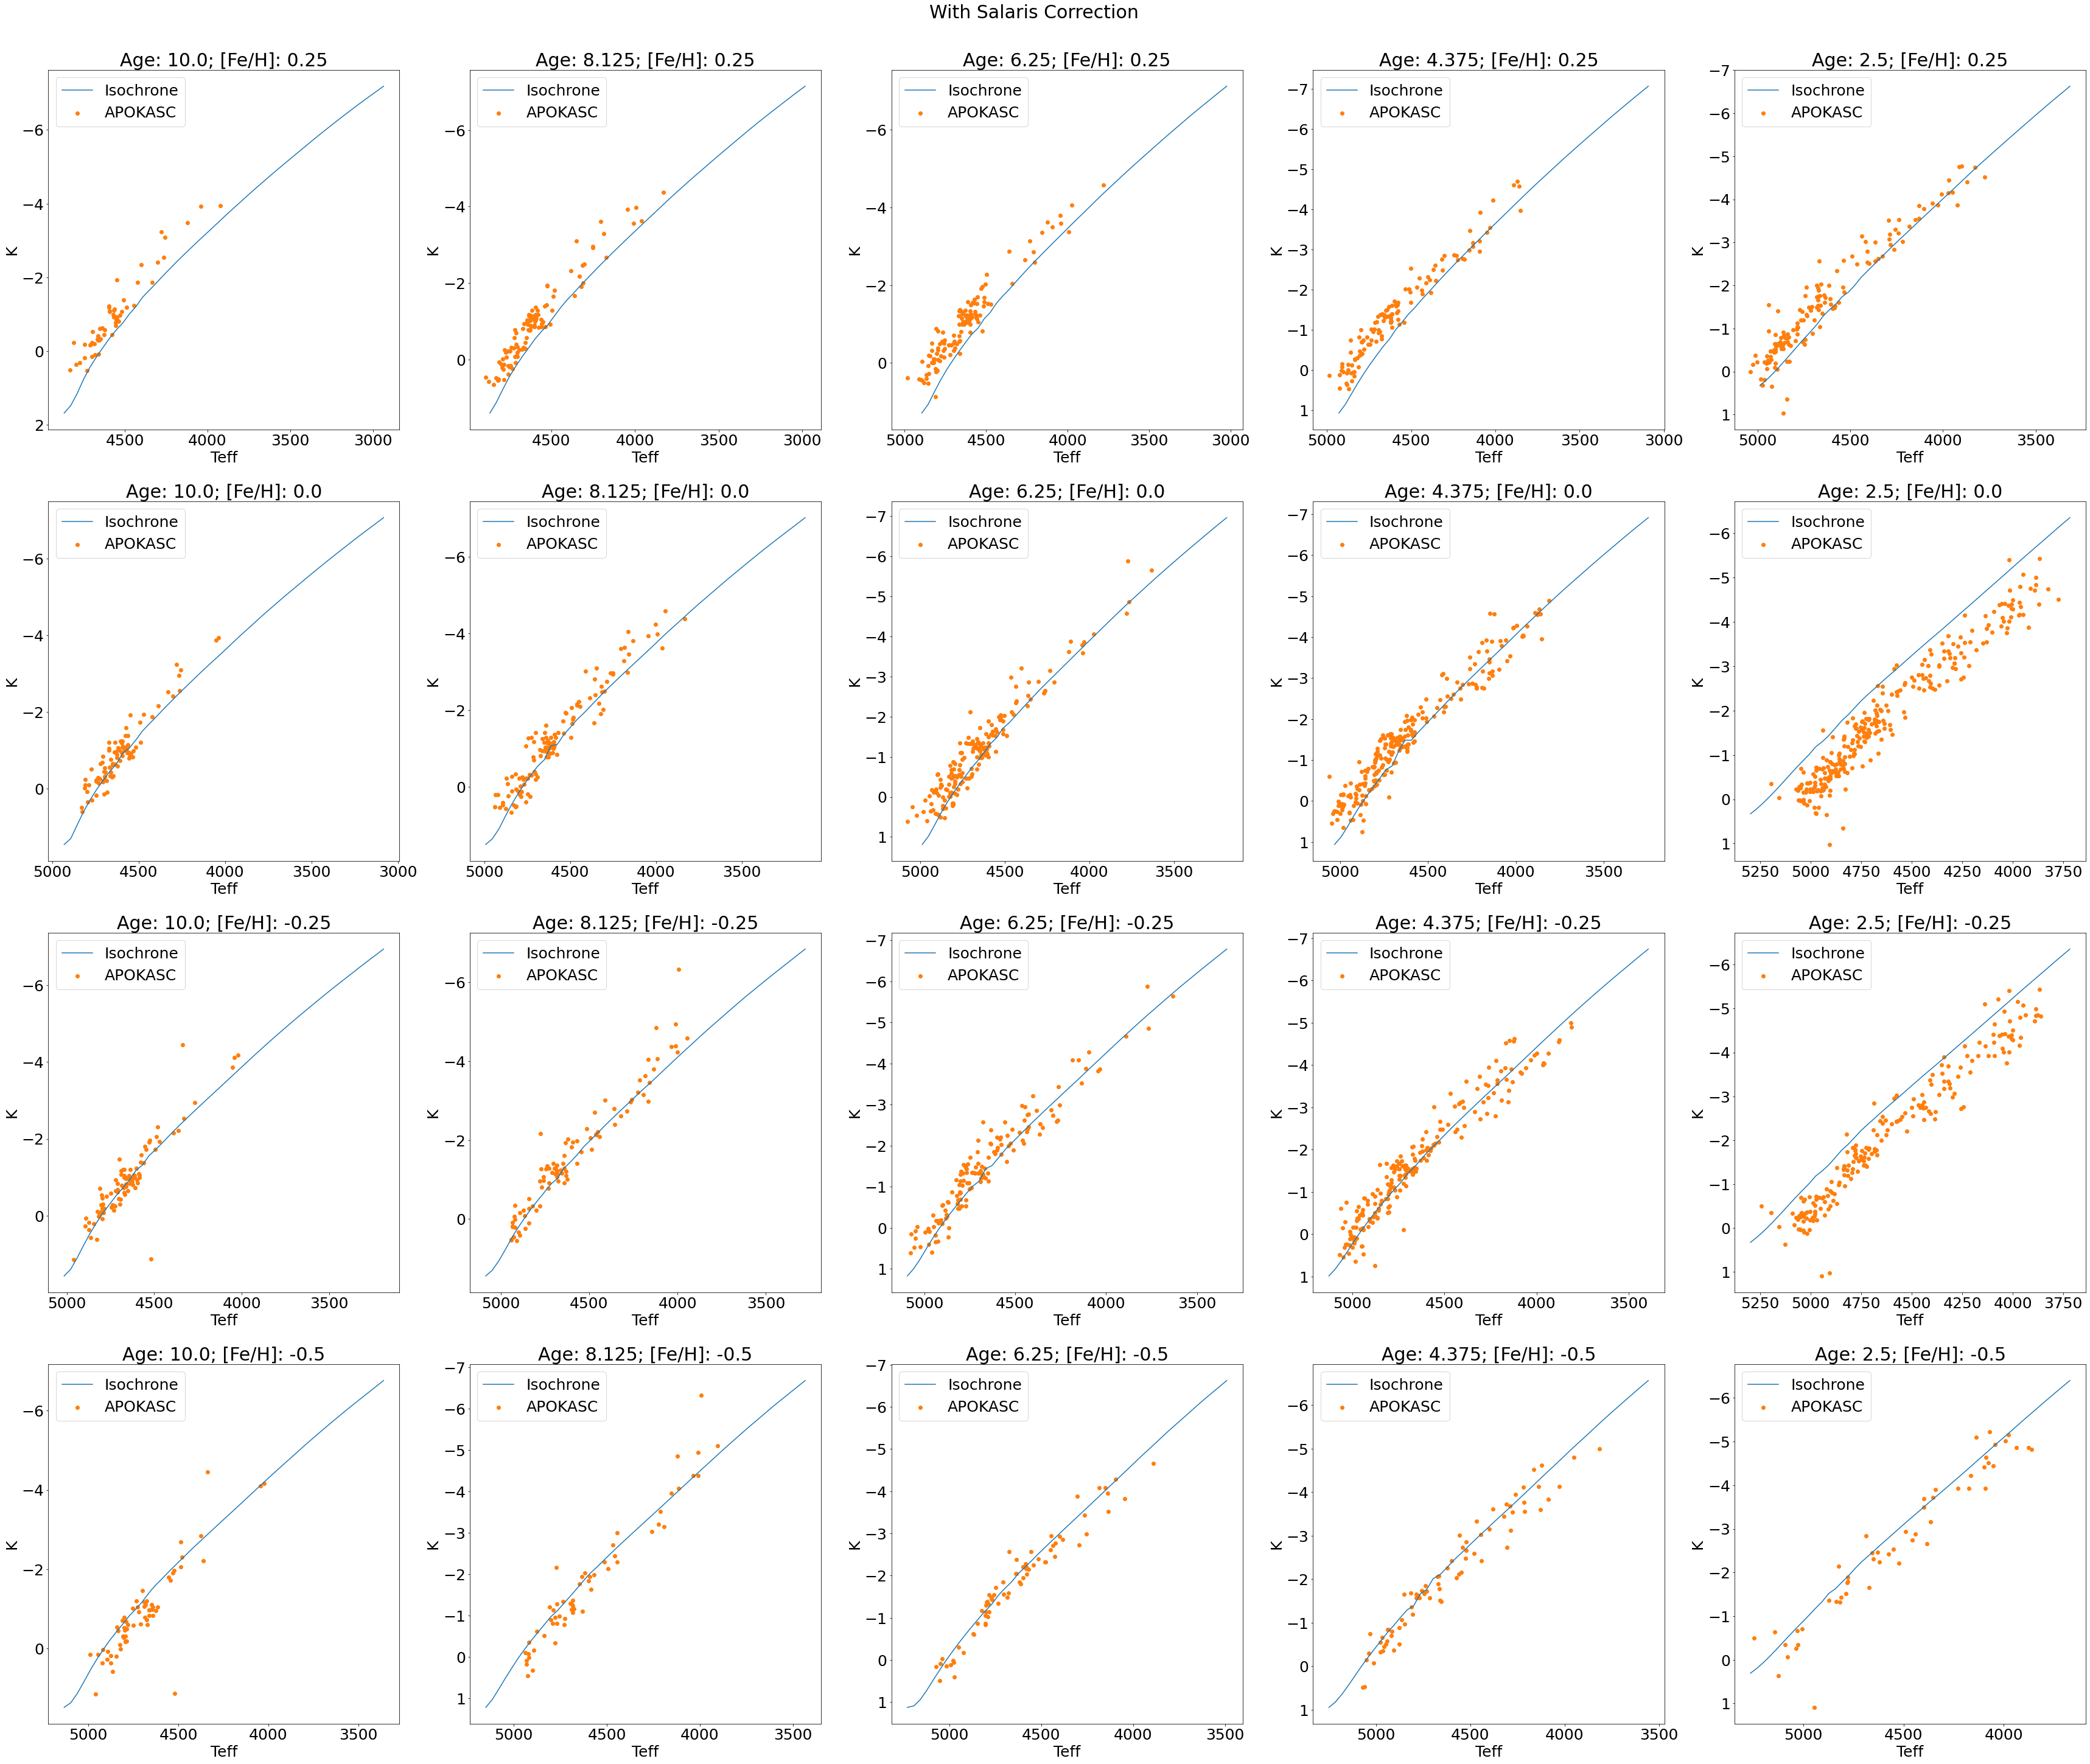

In [281]:
fehs = np.array([0.25,0.0,-0.25,-0.5])
ages = np.array([10,8.125,6.25,4.375,2.5])

mse_arr_absmag = np.zeros((4,5))

fig, ax = plt.subplots(4,5,figsize=[60,50])
for i in range(4):
    for j in range(5):
        
        stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
                                (k3dr17['Fe/H']<=fehs[i]+0.25)&(k3dr17['Fe/H']>=fehs[i]-0.25))
        
        stars = k3dr17[stars_select]
        
        stars17 = kdr17[stars_select]
        
        salcorr = np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
        slgte = np.argsort(stars['Teff'])
        stars = stars[slgte]
        stars17 = stars17[slgte]
        
        dmod = 5.*np.log10(1/stars17['GAIAEDR3_PARALLAX']*1000)-5.
        
        stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
                                     (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
        stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
        spl = IUS(10**stars_iso['logTe'][::2],stars_iso['Ksmag'][::2])
        spl_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        
        mse = np.sum(np.square(stars17['K']-spl(stars['Teff'])))/len(stars)
        mse_arr_absmag[i,j] = mse
        
        ax[i,j].scatter(stars['Teff'],stars17['K']-dmod,c='tab:orange',label='APOKASC')
        
        ax[i,j].plot(spl_xs,spl(spl_xs),c='tab:blue',label='Isochrone')
        
        ax[i,j].legend()
        
        ax[i,j].invert_xaxis()
        ax[i,j].invert_yaxis()
        
        ax[i,j].set_title(r'Age: {}; [Fe/H]: {}'.format(ages[j],fehs[i],mse))
        
        ax[i,j].set_xlabel(r'Teff')
        ax[i,j].set_ylabel(r'K')
        
plt.suptitle(r'With Salaris Correction',y=0.91)
plt.savefig('../plots/iso_comp_absmag_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

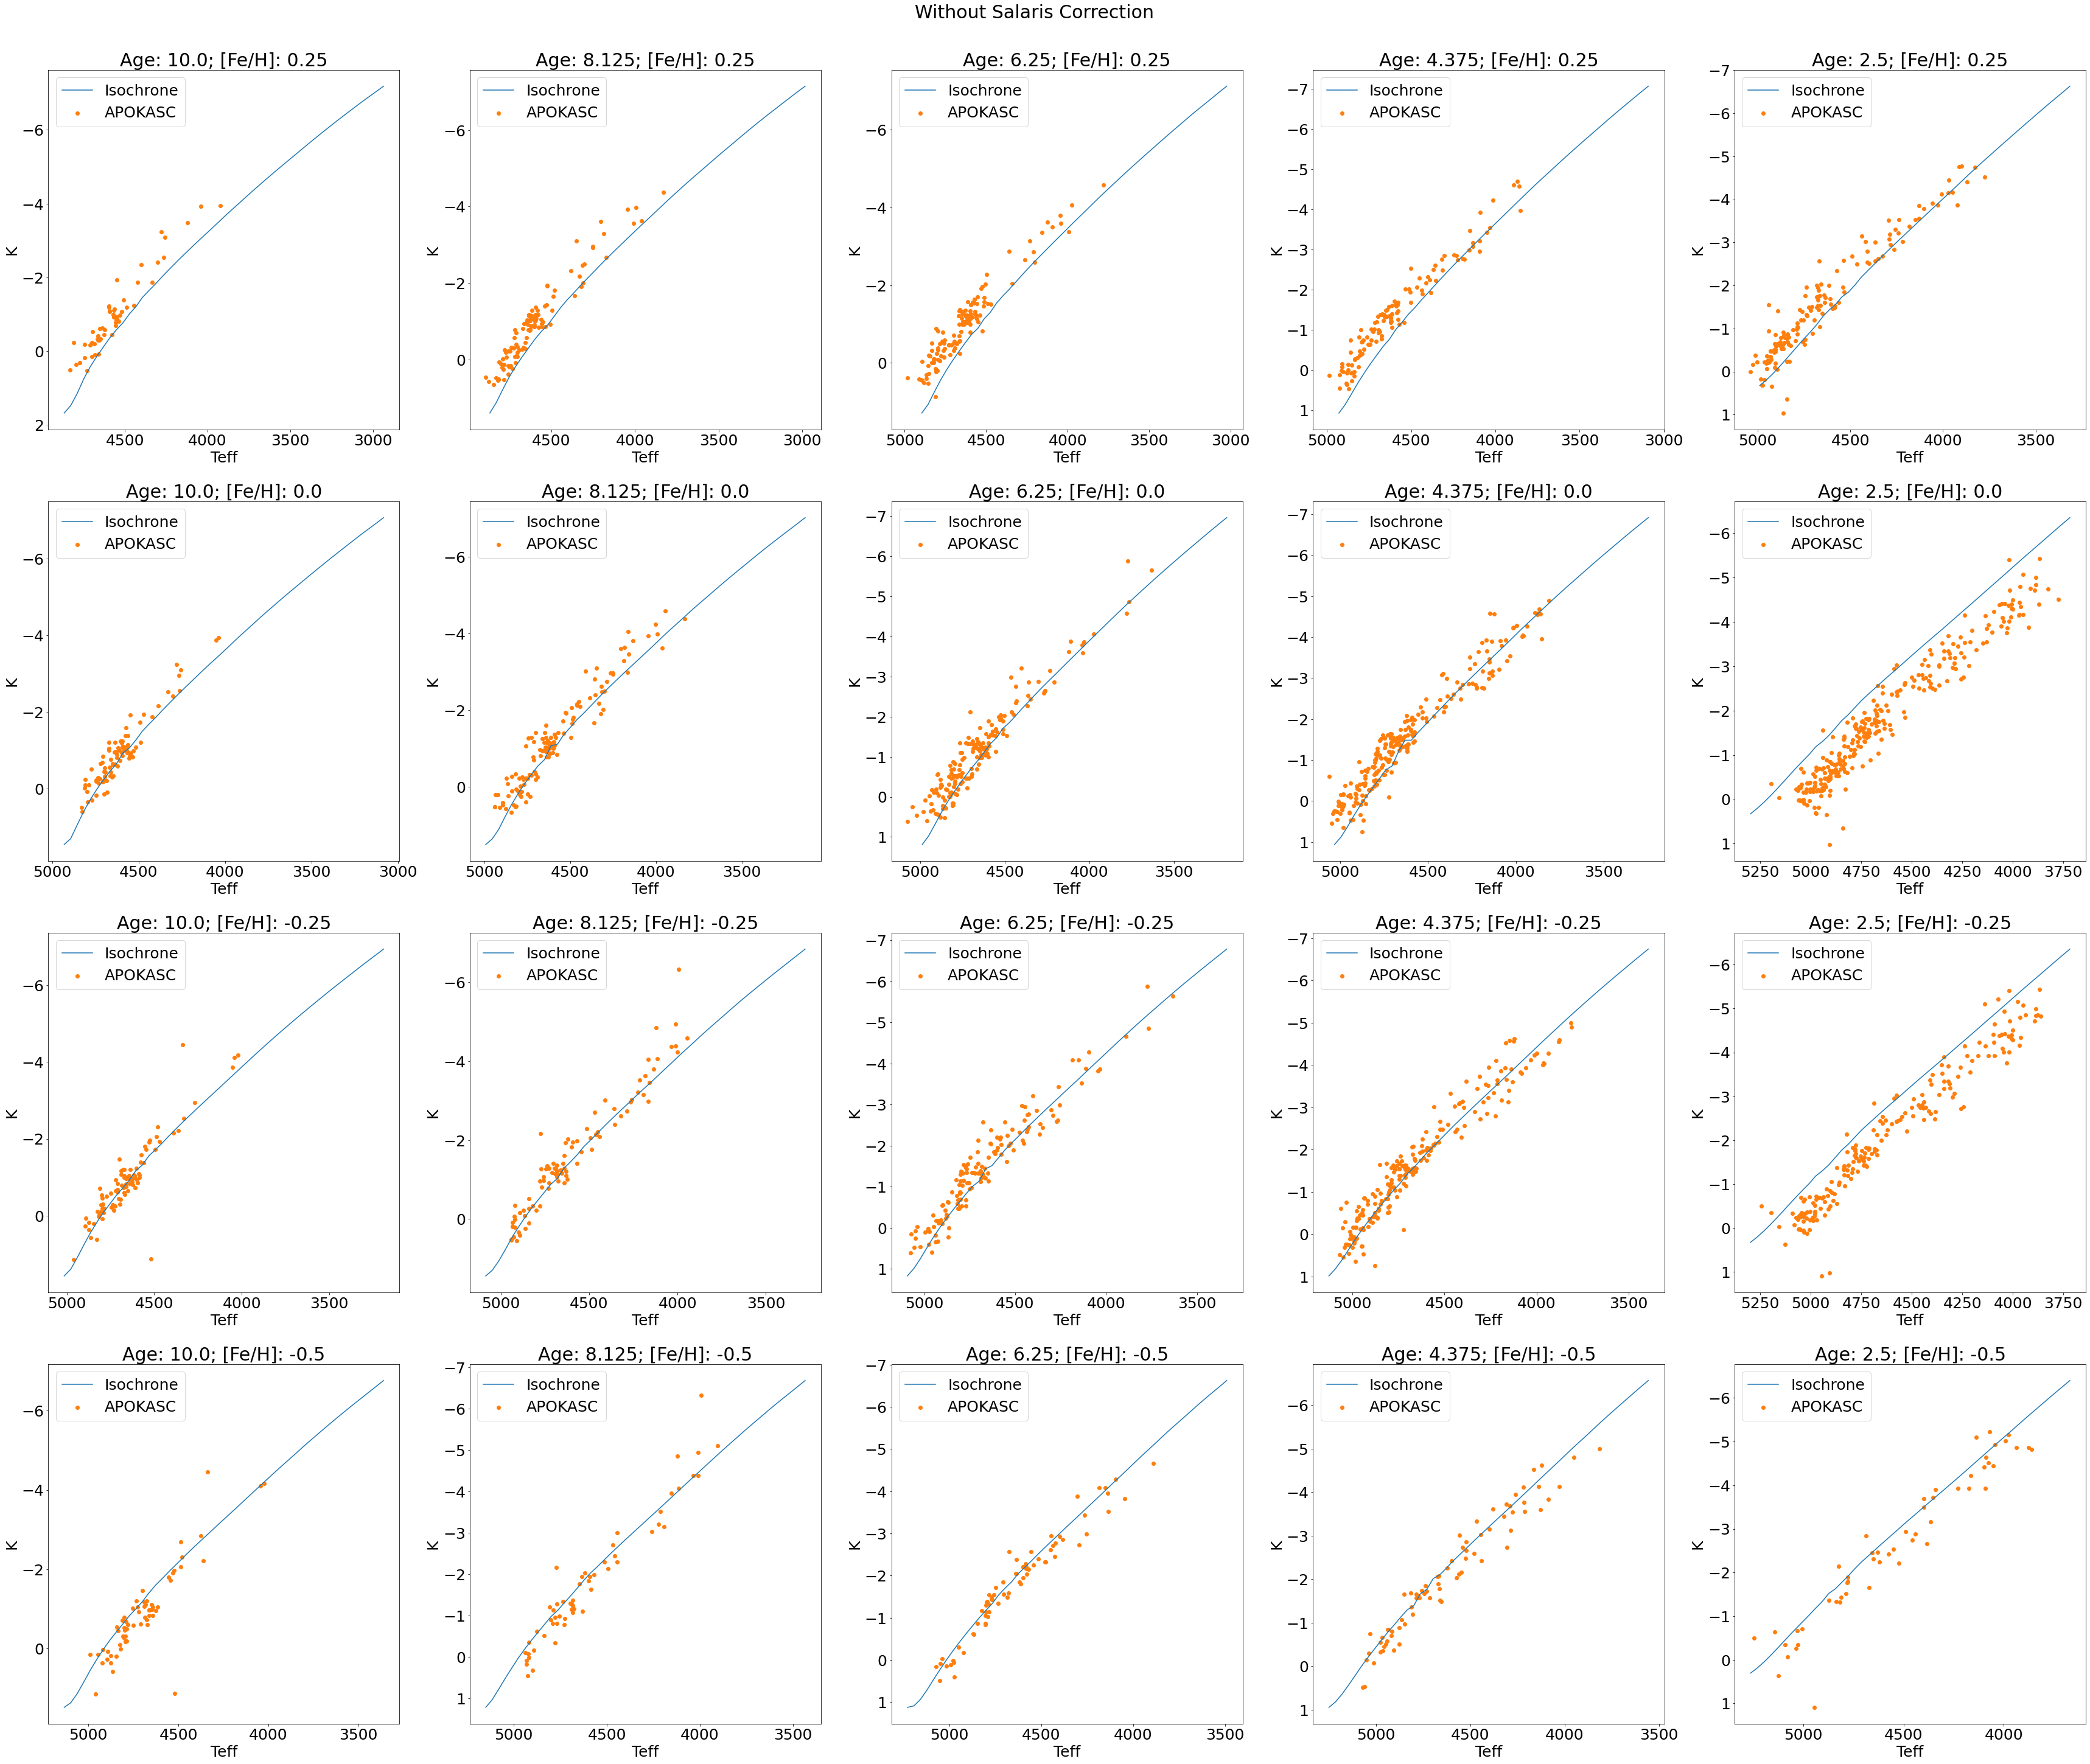

In [280]:
fehs = np.array([0.25,0.0,-0.25,-0.5])
ages = np.array([10,8.125,6.25,4.375,2.5])

fig, ax = plt.subplots(4,5,figsize=[60,50])
for i in range(4):
    for j in range(5):
        
        stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
                                (k3dr17['Fe/H']<=fehs[i]+0.25)&(k3dr17['Fe/H']>=fehs[i]-0.25))
        
        stars = k3dr17[stars_select]
        
        stars17 = kdr17[stars_select]
        
        salcorr = np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
        slgte = np.argsort(stars['Teff'])
        stars = stars[slgte]
        stars17 = stars17[slgte]
        
        dmod = 5.*np.log10(1/stars17['GAIAEDR3_PARALLAX']*1000)-5.
        
        stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+salcorr))&
                                     (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
        stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
        spl = IUS(10**stars_iso['logTe'][::2],stars_iso['Ksmag'][::2])
        spl_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        
        mse = np.sum(np.square(stars17['K']-spl(stars['Teff'])))/len(stars)
        
        ax[i,j].scatter(stars['Teff'],stars17['K']-dmod,c='tab:orange',label='APOKASC')
        
        ax[i,j].plot(spl_xs,spl(spl_xs),c='tab:blue',label='Isochrone')
        
        ax[i,j].legend()
        
        ax[i,j].invert_xaxis()
        ax[i,j].invert_yaxis()
        
        ax[i,j].set_title(r'Age: {}; [Fe/H]: {}'.format(ages[j],fehs[i],mse))
        
        ax[i,j].set_xlabel(r'Teff')
        ax[i,j].set_ylabel(r'K')
        
plt.suptitle(r'Without Salaris Correction',y=0.91)
plt.savefig('../plots/iso_comp_absmag.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [266]:
# plt.figure(figsize=[12,10])
# for i in range(4):
#     for j in range(5):
#         pl = plt.scatter(ages[j],fehs[i],c=mse_arr[i,j]/np.min(mse_arr),vmin=np.min(mse_arr)/np.min(mse_arr),
#                          vmax=np.max(mse_arr)/np.min(mse_arr),s=450,
#                          cmap='nipy_spectral')
# plt.colorbar(pl)
        
# plt.title(r'Color as MSE')
# plt.xlabel(r'Age (Gyr)')
# plt.ylabel(r'[Fe/H]')
# plt.savefig('../plots/MSE_isochrone_compare.pdf',dpi=300,bbox_inches='tight')
# plt.show()

In [253]:
# fehs = np.array([0.25,0.0,-0.25,-0.5])
# ages = np.array([10,8.125,6.25,4.375,2.5])

# mse_arr_salaris = np.zeros((4,5))

# fig, ax = plt.subplots(4,5,figsize=[60,50])
# for i in range(4):
#     for j in range(5):
        
#         stars_select = np.where((k3dr17['IntAge']>=ages[j]-0.25)&(k3dr17['IntAge']<=ages[j]+0.25)&
#                                 (k3dr17['Fe/H']<=fehs[i]+0.25)&(k3dr17['Fe/H']>=fehs[i]-0.25))
        
#         stars = k3dr17[stars_select]
        
#         med_alpha = np.median(np.log10(0.655*(10**(apoafe[stars_select]))+0.345))
        
#         stars_iso = massive[np.where((massive['MH']==closest(massive['MH'],fehs[i]+med_alpha))&
#                                      (massive['logAge']==closest(massive['logAge'],np.log10(ages[j]*10**9))))]
        
#         stars_iso = stars_iso[np.argsort(stars_iso['logTe'])]
        
#         line = np.poly1d(robust.polyfit(stars['Teff'],stars['Logg'],1))
#         line_xs = np.linspace(min(10**stars_iso['logTe']),max(10**stars_iso['logTe']))
        
#         mse = np.sum(np.square(stars_iso['logg']-line(10**stars_iso['logTe'])))/len(stars_iso)
#         mse_arr_salaris[i,j] = mse
        
#         ax[i,j].scatter(stars['Teff'],stars['Logg'],c='tab:orange',label='APOKASC')
#         ax[i,j].plot(10**stars_iso['logTe'],stars_iso['logg'],c='tab:blue',label='Isochrone')
        
#         ax[i,j].plot(line_xs,line(line_xs),c='tab:green',label='Best Fit')
        
#         ax[i,j].legend()
        
#         ax[i,j].invert_xaxis()
#         ax[i,j].invert_yaxis()
        
#         ax[i,j].set_title(r'Age: {}; [Fe/H]: {}; MSE: {:.5f}'.format(ages[j],fehs[i],mse))
        
#         ax[i,j].set_xlabel(r'Teff')
#         ax[i,j].set_ylabel(r'Log(g)')

# plt.suptitle(r'With Salaris Correction')
# plt.savefig('../plots/isochrone_compare_salaris.pdf',dpi=300,bbox_inches='tight')
# plt.show()

In [254]:
# plt.figure(figsize=[12,10])
# for i in range(4):
#     for j in range(5):
#         pl = plt.scatter(ages[j],fehs[i],c=mse_arr_salaris[i,j],
#                          vmin=np.min(mse_arr_salaris),vmax=np.max(mse_arr_salaris),s=450,
#                          cmap='nipy_spectral')
# plt.colorbar(pl)
        
# plt.title(r'Color as MSE')
# plt.xlabel(r'Age (Gyr)')
# plt.ylabel(r'[Fe/H]')
# plt.savefig('../plots/MSE_isochrone_compare_salaris.pdf',dpi=300,bbox_inches='tight')
# plt.show()

In [255]:
# plt.figure(figsize=[12,10])
# for i in range(4):
#     for j in range(5):
#         pl = plt.scatter(ages[j],fehs[i],c=mse_arr[i,j]-mse_arr_salaris[i,j],
#                          vmin=np.min(mse_arr-mse_arr_salaris),vmax=np.max(mse_arr-mse_arr_salaris),s=450,
#                          cmap='nipy_spectral')
# plt.colorbar(pl)
        
# plt.title(r'Color as MSE')
# plt.xlabel(r'Age (Gyr)')
# plt.ylabel(r'[Fe/H]')
# plt.savefig('../plots/MSE_isochrone_compare_difference.pdf',dpi=300,bbox_inches='tight')
# plt.show()